In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import ascii, fits
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u
from collections import defaultdict
from astropy.table import Table, vstack
from astropy.table import Table, vstack, join, join_skycoord
from collections import Counter
import scipy
import pylab
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib import colorbar
from matplotlib.patches import Ellipse
from matplotlib.ticker import LogFormatter
from matplotlib.ticker import LogFormatterExponent
from matplotlib.ticker import LogLocator
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import FixedLocator
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize
from astropy.table import Table, vstack, join
from astropy.io import ascii, fits
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import Counter
from matplotlib.lines import Line2D
from matplotlib.path import Path
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter
from astropy.stats import sigma_clip

# Fornax

In [2]:
## read Subaru HSC cat file
input_catfile = 'hsc_data/fornax_tpall3e_g24.cat'
df1 = ascii.read(input_catfile,
      names=['id', 'ra', 'dec', 'X', 'Y', 'ipsf', 'gpsf', 'npsf', 'ipsferr',
             'gpsferr', 'npsferr', 'cli', 'clg', 'cln', 'a_i', 'a_g', 'a_n'])
print(len(df1)) #381593
df1 = df1[(df1['cli'] == 0) & (df1['clg'] == 0) & (df1['cln'] == 0)]
print(len(df1)) #114831
df1['id'] = df1['id'].astype(float)
df1['g0'] = df1['gpsf'] - df1['a_g']
df1['i0'] = df1['ipsf'] - df1['a_i']
df1['n0'] = df1['npsf'] - df1['a_n']

381593
114831


In [3]:
## read DEIMOS fits file
input_fitsfile = 'deimos_data/alldsph_moogify.fits'
df2 = Table.read(input_fitsfile, format='fits')
df2 = df2[df2['DSPH'] == 'for   ']
df2 = df2[['DSPH', 'OBJNAME', 'MASK', 'SLIT', 'RA', 'DEC',
            'B', 'V', 'R', 'I', 'J', 'H', 'K', 'BERR', 'VERR', 'RERR', 'IERR', 'JERR', 'HERR', 'KERR', 'PHOT_COLOR',
            'AGE', 'TEFF', 'TEFFERR', 'LOGG', 'LOGGERR',
            'FEH', 'FEHERR', 'ALPHAFE', 'ALPHAFEERR', 'MGFE', 'MGFEERR', 'SIFE', 'SIFEERR', 'CAFE', 'CAFEERR', 'TIFE', 'TIFEERR']]
df2 = df2.to_pandas()
df2.loc[:,'by'] = 'Evan'
for column in df2.columns:
    if df2[column].dtype == 'object' and isinstance(df2[column][0], bytes):
        df2[column] = df2[column].str.decode('utf-8')
df2 = df2.sort_values(by=['RA'], ascending=True)
print(len(df2)) #669

td0 = df2[df2['RA'] == 39.883624998728436]
tn0 = df2[df2['RA'] == 39.903791666030884]
tn1 = df2[df2['RA'] == 40.02670833269755]
tn2 = df2[df2['RA'] == 40.071499999364214]
print(td0)
print(tn0)
print(tn1)
print(tn2)

bad_ra_values = [39.883624998728436, 39.903791666030884, 40.02670833269755, 40.071499999364214]
bad_df2 = df2[df2['RA'].isin(bad_ra_values)]
good_df2 = df2[~df2['RA'].isin(bad_ra_values)]
print('len(bad_df2) =', len(bad_df2)) #4
print('len(good_df2) =', len(good_df2)) #665

669
       DSPH           OBJNAME     MASK  SLIT         RA       DEC          B  \
221  for     37372             for3B     105  39.883625 -34.50225  21.117139   

         V          R      I  ...  ALPHAFEERR  MGFE  MGFEERR      SIFE  \
221 -999.0  19.924454 -999.0  ...    0.369185   1.2     -0.0  0.928742   

      SIFEERR      CAFE   CAFEERR      TIFE   TIFEERR    by  
221  0.439099  0.237162  0.912525 -0.009809  0.779954  Evan  

[1 rows x 39 columns]
       DSPH           OBJNAME     MASK  SLIT         RA        DEC          B  \
566  for     42747             for7       50  39.903792 -34.473667  21.040035   

         V          R      I  ...  ALPHAFEERR      MGFE   MGFEERR      SIFE  \
566 -999.0  19.650395 -999.0  ...     0.11947 -0.412151  0.400147  0.121115   

      SIFEERR      CAFE   CAFEERR      TIFE   TIFEERR    by  
566  0.147594  0.160599  0.208185  0.076838  0.134061  Evan  

[1 rows x 39 columns]
      DSPH           OBJNAME     MASK  SLIT         RA      DEC       

In [4]:
## read DEIMOS Lauren csv file
input_fitsfile = 'Mgabundances_Lauren/third/fulldataAlldSphs.csv'
df3 = pd.read_csv(input_fitsfile)
df3 = df3[['Name','RA','Dec','Galaxy','slitmask','Temp (K)','log(g)',
           '[Fe/H]','err([Fe/H])','[alpha/Fe]','[C/Fe]','[Mg/Fe]','errup([Mg/Fe])','errdown([Mg/Fe])','upper_[Mg/Fe]_twosigma','Mg_upperlimit',
           '[Sr/Fe]','errup([Sr/Fe])','errdown([Sr/Fe])','upper_[Sr/Fe]_twosigma','Sr_upperlimit',
           '[Y/Fe]','errup([Y/Fe])','errdown([Y/Fe])','upper_[Y/Fe]_twosigma','Y_upperlimit',
           '[Ba/Fe]','errup([Ba/Fe])','errdown([Ba/Fe])','upper_[Ba/Fe]_twosigma','Ba_upperlimit',
           '[La/Fe]','errup([La/Fe])','errdown([La/Fe])','upper_[La/Fe]_twosigma','La_upperlimit',
           '[Eu/Fe]','errup([Eu/Fe])','errdown([Eu/Fe])','upper_[Eu/Fe]_twosigma','Eu_upperlimit']]
df3 = df3[df3['Galaxy'] == 'Fornax']
df3.loc[:,'by'] = 'Lauren'
df3 = df3.sort_values(by=['RA'], ascending=True)
print(len(df3)) #201

201


In [5]:
#pd.options.mode.copy_on_write = True

df1['coord'] = SkyCoord(df1['ra'], df1['dec'], unit=(u.degree, u.degree))


bad_df2 = Table.from_pandas(bad_df2)
bad_df2['coord'] = SkyCoord(bad_df2['RA'], bad_df2['DEC'], unit=(u.degree, u.degree))

good_df2 = Table.from_pandas(good_df2)
good_df2['coord'] = SkyCoord(good_df2['RA'], good_df2['DEC'], unit=(u.degree, u.degree))


df3 = Table.from_pandas(df3)
df3['coord'] = SkyCoord(df3['RA'], df3['Dec'], unit=(u.degree, u.degree))

In [6]:
## match HSC and DEIMOS
import warnings
from astropy.io.fits.verify import VerifyWarning
warnings.filterwarnings('ignore', category=VerifyWarning)

def merge_catalogs(cat1, cat2, cat_names=['1', '2'], match_radius=0.1, join_type='outer'):
   ### Make the intersection of the two catalogs.###
   join_func = join_skycoord(match_radius * u.arcsec)
   j = join_func(cat1['coord'], cat2['coord'])
   data = join(cat1, cat2, keys='coord', join_funcs={'coord': join_func}, table_names=cat_names)
   return data

#The new header has 'header of df1' + 'coord_1.ra, coord_1.dec' + 'deimos header' + 'coord_2.ra, coord_2.dec'
#If the parameter names are same, it is changed, e.g., RA -> RA_1
bad_df12 = merge_catalogs(df1, bad_df2, cat_names=['1', '2'], match_radius=1, join_type='outer')
bad_df12 = bad_df12.to_pandas()
print('len(bad_df12) =', len(bad_df12)) #1
print(bad_df12['cli'])
print(bad_df12['i0'])
bad_df12_rm_dup = bad_df12[bad_df12['cli'] == 0]
print('len(bad_df12_rm_dup) =', len(bad_df12_rm_dup)) #1
print(bad_df12_rm_dup['i0'])

good_df12 = merge_catalogs(df1, good_df2, cat_names=['1', '2'], match_radius=1, join_type='outer')
good_df12 = good_df12.to_pandas()
print('len(good_df12) =', len(good_df12)) #496

df12 = pd.concat([bad_df12_rm_dup, good_df12], axis=0)
print('len(df12) =', len(df12)) #497

df12 = Table.from_pandas(df12)

df12.write('Fornax_HSC_DEIMOS.fits', format='fits', overwrite='True')
#df12.to_csv('Fornax_HSC_DEIMOS.csv', index=False)

len(bad_df12) = 1
0    0.0
Name: cli, dtype: float64
0    20.259064
Name: i0, dtype: float64
len(bad_df12_rm_dup) = 1
0    20.259064
Name: i0, dtype: float64
len(good_df12) = 496
len(df12) = 497


In [7]:
print(Counter(df12['cli']))
print(Counter(df12['clg']))
print(Counter(df12['cln']))

Counter({0.0: 497})
Counter({0.0: 497})
Counter({0.0: 497})


In [8]:
df13 = merge_catalogs(df1, df3, cat_names=['1', '2'], match_radius=1, join_type='outer')
df13 = df13.to_pandas()
print('len(df13) =', len(df13)) #146

df13 = Table.from_pandas(df13)

# Technically *_HSC_DEIMOS_Lauren should be correct because Lauren also measured DEIMOS data, 
# but I just ust *_HSC_Lauren since the names are confusing
df13.write('Fornax_HSC_Lauren.fits', format='fits', overwrite='True')
#df13.to_csv('Fornax_HSC_Lauren.csv', index=False)

len(df13) = 146


In [9]:
print(Counter(df13['cli']))
print(Counter(df13['clg']))
print(Counter(df13['cln']))

Counter({0.0: 146})
Counter({0.0: 146})
Counter({0.0: 146})


In [10]:
## Fornax
input_file_name = 'Fornax_HSC_DEIMOS.fits'
table = Table.read(input_file_name, format='fits')
table['id'] = table['id'].astype(str)
table = table[['DSPH', 'OBJNAME', 'MASK', 'SLIT', 'RA', 'DEC',
              'B', 'V', 'R', 'I', 'J', 'H', 'K', 'BERR', 'VERR', 'RERR', 'IERR', 'JERR', 'HERR', 'KERR', 'PHOT_COLOR',
              'AGE', 'TEFF', 'TEFFERR', 'LOGG', 'LOGGERR',
              'FEH', 'FEHERR', 'ALPHAFE', 'ALPHAFEERR', 'MGFE', 'MGFEERR', 'SIFE', 'SIFEERR', 'CAFE', 'CAFEERR', 'TIFE', 'TIFEERR',
              'id', 'ra', 'dec', 'X', 'Y', 'ipsf', 'gpsf', 'npsf', 'ipsferr', 'gpsferr', 'npsferr', 'cli', 'clg', 'cln', 'a_i', 'a_g', 'a_n',
              'g0','i0','n0','by']]
df_fnx_dei = table.to_pandas()
for column in df_fnx_dei.columns:
    if df_fnx_dei[column].dtype == 'object' and isinstance(df_fnx_dei[column][0], bytes):
        df_fnx_dei[column] = df_fnx_dei[column].str.decode('utf-8')
df_fnx_dei['MGH'] = df_fnx_dei['MGFE'] + df_fnx_dei['FEH']
df_fnx_dei['MGHERR'] = np.sqrt(df_fnx_dei['MGFEERR']**2 + df_fnx_dei['FEHERR']**2)
#df_fnx_dei = df_fnx_dei[(-0.0 < df_fnx_dei['MGFEERR']) & (df_fnx_dei['MGFEERR'] < 0.5)]

print('len(df_fnx_dei) =', len(df_fnx_dei)) #497
#print('len(df_fnx_dei MGFEERR <= -0.0 =', len(df_fnx_dei[df_fnx_dei['MGFEERR'] <= -0.0])) #
#df_fnx_dei = df_fnx_dei[-0.0 < df_fnx_dei['MGFEERR']]
#print('len(df_fnx_dei) =', len(df_fnx_dei)) #

len(df_fnx_dei) = 497


In [11]:
print(Counter(df_fnx_dei['clg']))
print(Counter(df_fnx_dei['cli']))
print(Counter(df_fnx_dei['cln']))

Counter({0.0: 497})
Counter({0.0: 497})
Counter({0.0: 497})


In [12]:
## Fornax
import warnings
from astropy.io.fits.verify import VerifyWarning
warnings.filterwarnings('ignore', category=VerifyWarning)

input_file_name = 'Fornax_HSC_Lauren.fits'
table = Table.read(input_file_name, format='fits')
table = table[['Name', 'RA', 'Dec', 'Temp (K)', 
               'log(g)', '[Fe/H]', 'err([Fe/H])', '[alpha/Fe]', '[Mg/Fe]', 'errup([Mg/Fe])', 'errdown([Mg/Fe])',
              'id', 'ra', 'dec', 'X', 'Y', 'ipsf', 'gpsf', 'npsf', 'ipsferr', 'gpsferr', 'npsferr', 'cli', 'clg', 'cln', 'a_i', 'a_g', 'a_n',
              'g0','i0','n0','by']]
df_fnx_lau = table.to_pandas()
df_fnx_lau['DSPH'] = 'for'
df_fnx_lau.rename(columns={'Name':'OBJNAME', 'Dec':'DEC', 'Temp (K)':'TEFF', 'log(g)':'LOGG',
                           '[Fe/H]':'FEH', 'err([Fe/H])':'FEHERR', '[alpha/Fe]':'ALPHAFE', '[Mg/Fe]':'MGFE'}, inplace=True)
df_fnx_lau['MGFEERR'] = (df_fnx_lau['errup([Mg/Fe])'] + df_fnx_lau['errdown([Mg/Fe])']) / 2.
df_fnx_lau.drop(['errup([Mg/Fe])', 'errdown([Mg/Fe])'], axis=1, inplace=True)
df_fnx_lau[['MASK','SLIT','B', 'V', 'R', 'I', 'J', 'H', 'K', 'BERR', 'VERR', 'RERR', 'IERR', 'JERR', 'HERR', 'KERR', 'PHOT_COLOR',
            'AGE','TEFFERR','LOGGERR','ALPHAFEERR','SIFE', 'SIFEERR', 'CAFE', 'CAFEERR', 'TIFE', 'TIFEERR']] = np.nan

for column in df_fnx_lau.columns:
    if df_fnx_lau[column].dtype == 'object' and isinstance(df_fnx_lau[column][0], bytes):
        df_fnx_lau[column] = df_fnx_lau[column].str.decode('utf-8')
df_fnx_lau['MGH'] = df_fnx_lau['MGFE'] + df_fnx_lau['FEH']
df_fnx_lau['MGHERR'] = np.sqrt(df_fnx_lau['MGFEERR']**2 + df_fnx_lau['FEHERR']**2)

df_fnx_lau = df_fnx_lau[['DSPH', 'OBJNAME', 'MASK', 'SLIT', 'RA', 'DEC',
              'B', 'V', 'R', 'I', 'J', 'H', 'K', 'BERR', 'VERR', 'RERR', 'IERR', 'JERR', 'HERR', 'KERR', 'PHOT_COLOR',
              'AGE', 'TEFF', 'TEFFERR', 'LOGG', 'LOGGERR',
              'FEH', 'FEHERR', 'ALPHAFE', 'ALPHAFEERR', 'MGFE', 'MGFEERR', 'MGH', 'MGHERR', 'SIFE', 'SIFEERR', 'CAFE', 'CAFEERR', 'TIFE', 'TIFEERR',
              'id', 'ra', 'dec', 'X', 'Y', 'ipsf', 'gpsf', 'npsf', 'ipsferr', 'gpsferr', 'npsferr', 'cli', 'clg', 'cln', 'a_i', 'a_g', 'a_n',
              'g0','i0','n0','by']]

print('len(df_fnx_lau) =', len(df_fnx_lau)) #146

len(df_fnx_lau) = 146


In [13]:
print(Counter(df_fnx_lau['clg']))
print(Counter(df_fnx_lau['cli']))
print(Counter(df_fnx_lau['cln']))

Counter({0.0: 146})
Counter({0.0: 146})
Counter({0.0: 146})


In [14]:
print(Counter(df_fnx_dei['DSPH']))
print(Counter(df_fnx_lau['DSPH']))

Counter({'for': 497})
Counter({'for': 146})


In [15]:
df_fnx = pd.concat([df_fnx_dei, df_fnx_lau], axis=0)
print(df_fnx) #643

    DSPH OBJNAME   MASK   SLIT         RA        DEC          B      V  \
0    for   37372  for3B  105.0  39.883625 -34.502250  21.117139 -999.0   
1    for  104258  for1B   83.0  40.153292 -34.551667  21.463742 -999.0   
2    for  105648  for1B   16.0  40.162792 -34.548944  20.712590 -999.0   
3    for  101263  for1B   54.0  40.134417 -34.546778  20.353793 -999.0   
4    for  101800  for1B    2.0  40.137625 -34.546444  20.004977 -999.0   
..   ...     ...    ...    ...        ...        ...        ...    ...   
141  for   31612    NaN    NaN  39.861583 -34.397472        NaN    NaN   
142  for   37809    NaN    NaN  39.885417 -34.396000        NaN    NaN   
143  for   36175    NaN    NaN  39.879167 -34.393861        NaN    NaN   
144  for   33204    NaN    NaN  39.867708 -34.391750        NaN    NaN   
145  for   23551    NaN    NaN  39.828958 -34.459333        NaN    NaN   

             R      I  ...  cln     a_i     a_g     a_n         g0         i0  \
0    19.924454 -999.0  ...  0.

In [16]:
print(Counter(df_fnx['DSPH'])) #Counter({'for': 643})
df_fnx = df_fnx.drop_duplicates(subset=['id'], keep='first') #keep the first one among dups
print(len(df_fnx)) #643

Counter({'for': 643})
643


In [17]:
test = df_fnx[(df_fnx['gpsferr'] != np.inf) & (df_fnx['ipsferr'] != np.inf) & (df_fnx['npsferr'] != np.inf)]
print(len(test))

643


In [18]:
print(df_fnx.columns.values)

['DSPH' 'OBJNAME' 'MASK' 'SLIT' 'RA' 'DEC' 'B' 'V' 'R' 'I' 'J' 'H' 'K'
 'BERR' 'VERR' 'RERR' 'IERR' 'JERR' 'HERR' 'KERR' 'PHOT_COLOR' 'AGE'
 'TEFF' 'TEFFERR' 'LOGG' 'LOGGERR' 'FEH' 'FEHERR' 'ALPHAFE' 'ALPHAFEERR'
 'MGFE' 'MGFEERR' 'SIFE' 'SIFEERR' 'CAFE' 'CAFEERR' 'TIFE' 'TIFEERR' 'id'
 'ra' 'dec' 'X' 'Y' 'ipsf' 'gpsf' 'npsf' 'ipsferr' 'gpsferr' 'npsferr'
 'cli' 'clg' 'cln' 'a_i' 'a_g' 'a_n' 'g0' 'i0' 'n0' 'by' 'MGH' 'MGHERR']


In [19]:
df_fnx.to_csv('Fornax_HSC_Evan_Lauren_before_pm.csv', index=False)

In [20]:
"""
# Plots of mag err
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(10, 3), gridspec_kw={'wspace':0.3})

ax0.hist(df_fnx['gpsferr'], bins=10, histtype='step', linestyle='solid', color='k')
ax0.set_xlim([-0.01, 0.15])
ax0.set_xlabel('Err_g$_{0}$', size=12)
ax0.set_ylabel('Numbers', size=12)
ax0.axvline(0.02, 0, 40000, color='blue', linestyle='-', alpha=0.5)
ax1.hist(df_fnx['npsferr'], bins=10, histtype='step', linestyle='solid', color='k')
ax1.set_xlim([-0.01, 0.15])
ax1.set_xlabel('Err_n$_{0}$', size=12)
ax1.set_ylabel('Numbers', size=12)
ax1.axvline(0.02, 0, 40000, color='blue', linestyle='-', alpha=0.5)
ax2.hist(df_fnx['ipsferr'], bins=10, histtype='step', linestyle='solid', color='k')
ax2.set_xlim([-0.01, 0.15])
ax2.set_xlabel('Err_i$_{0}$', size=12)
ax2.set_ylabel('Numbers', size=12)
ax2.axvline(0.02, 0, 40000, color='blue', linestyle='-', alpha=0.5)
plt.show()
"""

# Apply the magnitude err
df_fnx_mag_err = df_fnx[(df_fnx['gpsferr'] < 0.02) & (df_fnx['ipsferr'] < 0.02) & (df_fnx['npsferr'] < 0.02)]
print(f'After mag err cut, \ndf_fnx_mag_err = {len(df_fnx_mag_err)}') #637

After mag err cut, 
df_fnx_mag_err = 637


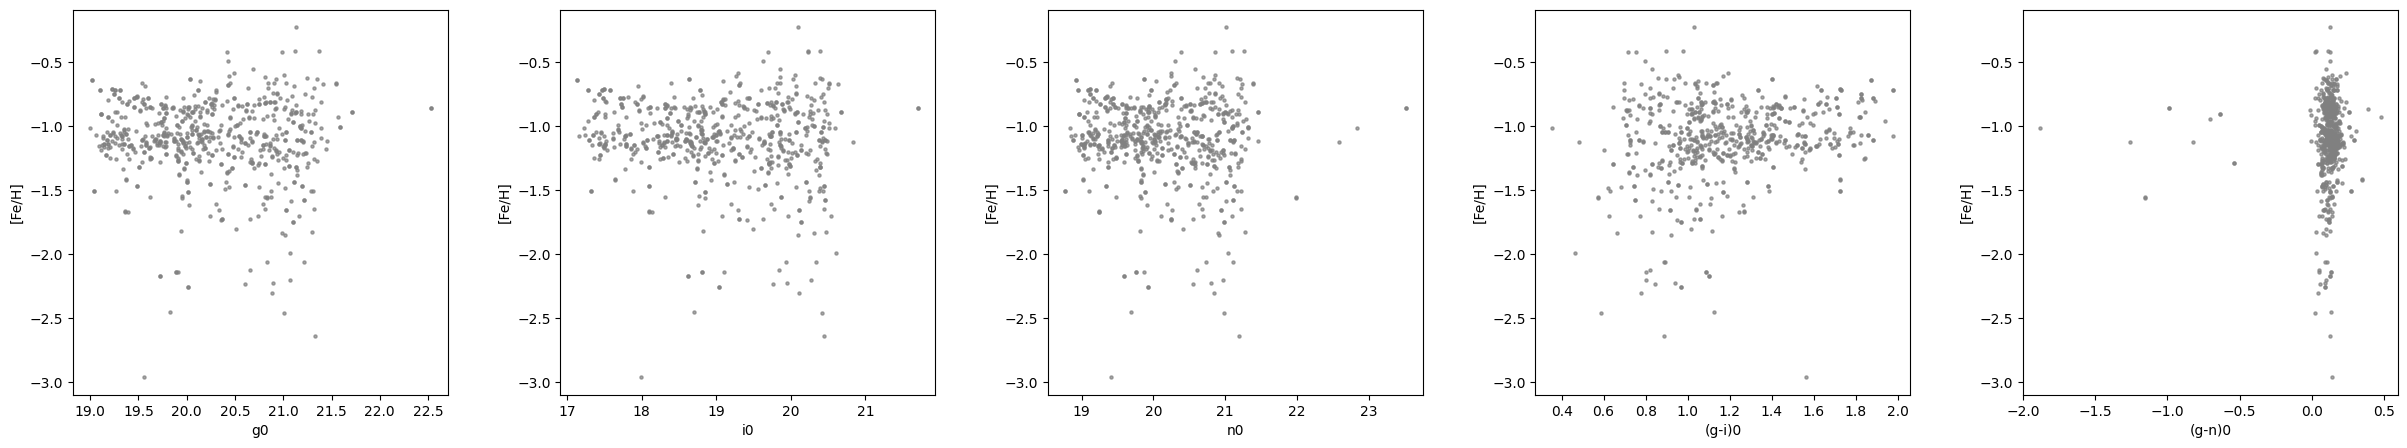

In [21]:
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=5, figsize=(30,5), gridspec_kw={'wspace':0.3})

ax0.scatter(df_fnx['g0'], df_fnx['FEH'], s=5, color='gray', alpha=.7)
ax0.set_xlabel('g0')
ax0.set_ylabel('[Fe/H]')

ax1.scatter(df_fnx['i0'], df_fnx['FEH'], s=5, color='gray', alpha=.7)
ax1.set_xlabel('i0')
ax1.set_ylabel('[Fe/H]')

ax2.scatter(df_fnx['n0'], df_fnx['FEH'], s=5, color='gray', alpha=.7)
ax2.set_xlabel('n0')
ax2.set_ylabel('[Fe/H]')

ax3.scatter(df_fnx['g0']-df_fnx['i0'], df_fnx['FEH'], s=5, color='gray', alpha=.7)
ax3.set_xlabel('(g-i)0')
ax3.set_ylabel('[Fe/H]')

ax4.scatter(df_fnx['g0']-df_fnx['n0'], df_fnx['FEH'], s=5, color='gray', alpha=.7)
ax4.set_xlabel('(g-n)0')
ax4.set_ylabel('[Fe/H]')

#plt.show()
plt.savefig('DEIMOS_non_linear_relationships_Fornax.png', bbox_inches='tight')

len(df1_gaia) = 643
len(df1_gaia_sc) = 643
len(df1_gaia_sc_magerr) = 637
len(df1_gaia_sc_magerr_availpm) = 637
len(df1_gaia_sc_magerr_nonpm) = 0
clipped mean pmRA pmDE = 0.38 -0.326
clipped std pmRA pmDE = 0.2 0.328
r_a, r_b = 0.6 0.984
len(filtered data) = 637
len(inside the ellipse) = 554
len(filtered_df1_gaia_sc_magerr_availpm_nonpm) = 637
len(df1_gaia_sc_magerr_availpm_inside_polygon) = 628


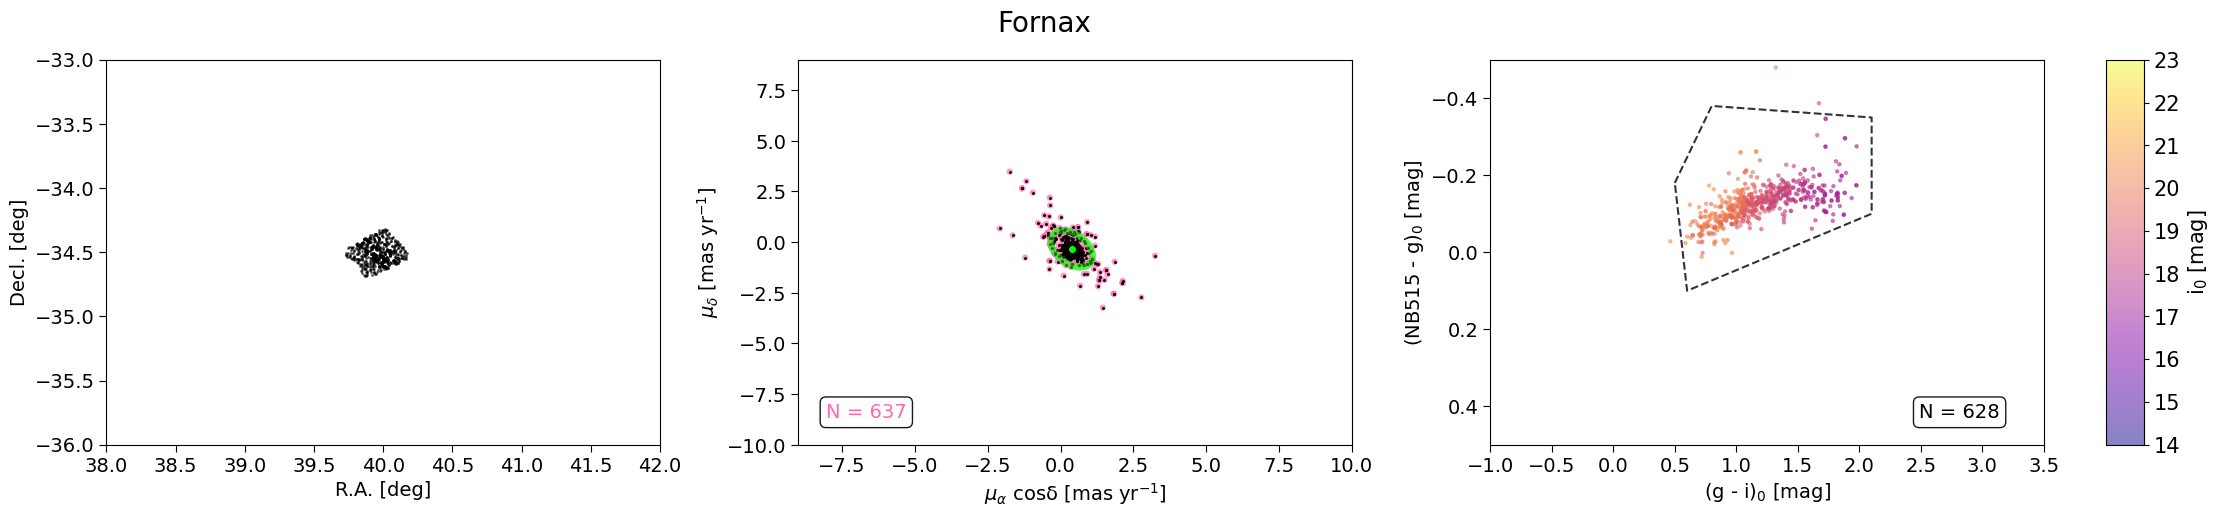

In [97]:
# The sample with Gaia DR3 proper motion
df1_gaia = pd.read_csv('Fornax_HSC_Evan_Lauren_after_pm.csv')
print(f'len(df1_gaia) = {len(df1_gaia)}') #643
df1_gaia_sc = df1_gaia[(df1_gaia['cli'] == 0) & (df1_gaia['clg'] == 0) & (df1_gaia['cln'] == 0)]
print(f'len(df1_gaia_sc) = {len(df1_gaia_sc)}') #643
df1_gaia_sc_magerr = df1_gaia_sc[(df1_gaia_sc['gpsferr'] < 0.02) & (df1_gaia_sc['ipsferr'] < 0.02) & (df1_gaia_sc['npsferr'] < 0.02)]
print(f'len(df1_gaia_sc_magerr) = {len(df1_gaia_sc_magerr)}') #637
df1_gaia_sc_magerr_availpm = df1_gaia_sc_magerr[df1_gaia_sc_magerr['pmRA'].notnull()]
print('len(df1_gaia_sc_magerr_availpm) =', len(df1_gaia_sc_magerr_availpm)) #637
df1_gaia_sc_magerr_nonpm = df1_gaia_sc_magerr[df1_gaia_sc_magerr['pmRA'].isnull()]
print('len(df1_gaia_sc_magerr_nonpm) =', len(df1_gaia_sc_magerr_nonpm)) #0

# Left
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(25, 5), gridspec_kw={'wspace':0.25})
fig.suptitle('Fornax', size=20, y=0.98)
alpha = .5 ; s = 5
axs[0].scatter(df1_gaia_sc_magerr_availpm['ra'], df1_gaia_sc_magerr_availpm['dec'], marker='.', s=s, color='k', alpha=.5)
axs[0].set_xlabel('R.A. [deg]', size=14)
axs[0].set_ylabel('Decl. [deg]', size=14)
axs[0].set_xlim([38, 42])
axs[0].set_ylim([-36, -33])
axs[0].tick_params(axis='x', which='major', direction='out', right=False, top=False, length=5, labelsize=14)
axs[0].tick_params(axis='x', which='minor', direction='out', right=False, top=False, length=3, labelsize=14)
axs[0].tick_params(axis='y', which='major', direction='out', right=False, top=False, length=5, labelsize=14)
axs[0].tick_params(axis='y', which='minor', direction='out', right=False, top=False, length=3, labelsize=14)


# Middle
#pmra_0, pmdec_0 = 0.380, -0.416 # McConnachie et al. 2020
#r_a, r_b = 2.6, 1.35 # manually / pmRA pmDE std = 8.18, 7.24 # too big
pmRA = df1_gaia_sc_magerr_availpm['pmRA']
pmDE = df1_gaia_sc_magerr_availpm['pmDE']
err_pmra = df1_gaia_sc_magerr_availpm['e_pmRA']
err_pmdec = df1_gaia_sc_magerr_availpm['e_pmDE']
err_pm = np.sqrt(err_pmra**2 + err_pmdec**2)
# Sigma Clipping
clipped_pmRA = sigma_clip(pmRA, sigma=3, maxiters=10, stdfunc=np.std)
clipped_pmDE = sigma_clip(pmDE, sigma=3, maxiters=10, stdfunc=np.std)
mean_pmRA = np.round(np.mean(clipped_pmRA), 3)
mean_pmDE = np.round(np.mean(clipped_pmDE), 3)
std_pmRA = np.round(np.std(clipped_pmRA), 3)
std_pmDE = np.round(np.std(clipped_pmDE), 3)
print('clipped mean pmRA pmDE =', mean_pmRA, mean_pmDE) #0.411 -0.426
print('clipped std pmRA pmDE =', std_pmRA, std_pmDE) #0.628 1.033
pmra_0, pmdec_0 = mean_pmRA, mean_pmDE
r_a, r_b = np.round(std_pmRA * 3, 3), np.round(std_pmDE * 3, 3)
print('r_a, r_b =', r_a, r_b) #1.884 3.099
axs[1].plot(pmra_0, pmdec_0, marker='o', markersize=4, color='lime')
ellipse = Ellipse(xy=[pmra_0, pmdec_0], width=r_a*2, height=r_b*2, angle=30, edgecolor='lime', fc='None', lw=5, alpha=0.5)
axs[1].add_patch(ellipse)
angle = ellipse.angle

def within_ellipse(x, y, x_0, y_0, r_a, r_b):
    theta = np.radians(360 - angle)
    x_rot = x * np.cos(theta) - y * np.sin(theta)
    y_rot = x * np.sin(theta) + y * np.cos(theta)
    x_0_rot = x_0 * np.cos(theta) - y_0 * np.sin(theta)
    y_0_rot = x_0 * np.sin(theta) + y_0 * np.cos(theta)
    return ( (r_b * (x_rot - x_0_rot))**2 + (r_a * (y_rot - y_0_rot))**2 ) <= (r_a * r_b)**2

def within_ellipse_w_errpm(x, y, x_0, y_0, r_a, r_b, err_pm):
    theta = np.radians(360 - angle)
    x_rot = x * np.cos(theta) - y * np.sin(theta)
    y_rot = x * np.sin(theta) + y * np.cos(theta)
    x_0_rot = x_0 * np.cos(theta) - y_0 * np.sin(theta)
    y_0_rot = x_0 * np.sin(theta) + y_0 * np.cos(theta)
    return ( (r_b * (x_rot - x_0_rot))**2 + (r_a * (y_rot - y_0_rot))**2 ) <= (r_a * r_b)**2 + (3 * err_pm)**2

theta = np.radians(360 - angle)

mask = df1_gaia_sc_magerr_availpm.apply(lambda row: within_ellipse_w_errpm(row['pmRA'], row['pmDE'], pmra_0, pmdec_0, r_a, r_b, np.sqrt(row['e_pmRA']**2 + row['e_pmDE']**2)), axis=1)
filtered_df1_gaia_sc_magerr_availpm = df1_gaia_sc_magerr_availpm[mask]
print('len(filtered data) =', len(filtered_df1_gaia_sc_magerr_availpm)) #637
axs[1].scatter(filtered_df1_gaia_sc_magerr_availpm['pmRA'], filtered_df1_gaia_sc_magerr_availpm['pmDE'], marker='o', s=20, facecolor='hotpink', edgecolor='none', alpha=0.7)
props = dict(boxstyle='round', facecolor='white', alpha=0.9)
axs[1].text(0.05, 0.07, 'N = {}'.format(len(filtered_df1_gaia_sc_magerr_availpm)), transform=axs[1].transAxes, fontsize=14, color='hotpink', bbox=props)

axs[1].scatter(df1_gaia_sc_magerr_availpm['pmRA'], df1_gaia_sc_magerr_availpm['pmDE'], marker='.', s=s, color='k', alpha=1)
axs[1].set_xlabel('$\mu_{\\alpha}~\mathrm{cos\delta}$ [mas yr$^{-1}$]', size=14)
axs[1].set_ylabel('$\mu_{\delta}$ [mas yr$^{-1}$]', size=14)
axs[1].set_xlim([-9, 10])
axs[1].set_ylim([-10, 9])
axs[1].add_patch(ellipse)
axs[1].tick_params(axis='x', which='major', direction='out', right=False, top=False, length=5, labelsize=14)
axs[1].tick_params(axis='x', which='minor', direction='out', right=False, top=False, length=3, labelsize=14)
axs[1].tick_params(axis='y', which='major', direction='out', right=False, top=False, length=5, labelsize=14)
axs[1].tick_params(axis='y', which='minor', direction='out', right=False, top=False, length=3, labelsize=14)

mask_test = df1_gaia_sc_magerr_availpm.apply(lambda row: within_ellipse(row['pmRA'], row['pmDE'], pmra_0, pmdec_0, r_a, r_b), axis=1)
inside_ellipse_test = df1_gaia_sc_magerr_availpm[mask_test]
print('len(inside the ellipse) =', len(inside_ellipse_test)) #554

filtered_df1_gaia_sc_magerr_availpm_nonpm = pd.concat([df1_gaia_sc_magerr_nonpm, filtered_df1_gaia_sc_magerr_availpm], axis=0)
print('len(filtered_df1_gaia_sc_magerr_availpm_nonpm) =', len(filtered_df1_gaia_sc_magerr_availpm_nonpm)) #637


# Right
cax = fig.add_axes([axs[2].get_position().x1+0.025, axs[2].get_position().y0, 0.015, axs[2].get_position().height])
img = axs[2].scatter(filtered_df1_gaia_sc_magerr_availpm['g0'] - filtered_df1_gaia_sc_magerr_availpm['i0'], 
                     filtered_df1_gaia_sc_magerr_availpm['n0'] - filtered_df1_gaia_sc_magerr_availpm['g0'], 
                     marker='o', s=s, c=filtered_df1_gaia_sc_magerr_availpm['i0'], cmap='plasma', alpha=alpha)
axs[2].set_xlim([-1, 3.5])
axs[2].set_ylim([0.5, -0.5])
axs[2].set_xlabel('(g - i)$_{0}$ [mag]', size=14)
axs[2].set_ylabel('(NB515 - g)$_{0}$ [mag]', size=14)
axs[2].tick_params(axis='x', which='major', direction='out', right=False, top=False, length=5, labelsize=14)
axs[2].tick_params(axis='x', which='minor', direction='out', right=False, top=False, length=3, labelsize=14)
axs[2].tick_params(axis='y', which='major', direction='out', right=False, top=False, length=5, labelsize=14)
axs[2].tick_params(axis='y', which='minor', direction='out', right=False, top=False, length=3, labelsize=14)
cbar = plt.colorbar(img, cax=cax)
cbar.ax.tick_params(labelsize=15)
cbar.set_label('i$_{0}$ [mag]', size=15)
cbar.mappable.set_clim(vmin=14, vmax=23)
cbar.update_ticks()
coord = [[0.5, -0.18], [0.8, -0.38], [2.1, -0.35], [2.1, -0.1], [0.6, 0.1], [0.5, -0.18]]
xs, ys = zip(*coord)
axs[2].plot(xs, ys, linestyle='--', linewidth=1.5, alpha=.8, color='k')
polygon = Path(coord)
points = np.vstack((filtered_df1_gaia_sc_magerr_availpm['g0'] - filtered_df1_gaia_sc_magerr_availpm['i0'], 
                    filtered_df1_gaia_sc_magerr_availpm['n0'] - filtered_df1_gaia_sc_magerr_availpm['g0'])).T
inside = polygon.contains_points(points)
df1_gaia_sc_magerr_availpm_inside_polygon = filtered_df1_gaia_sc_magerr_availpm[inside]
props = dict(boxstyle='round', facecolor='white', alpha=0.9)
axs[2].text(0.775, 0.07, 'N = {}'.format(len(df1_gaia_sc_magerr_availpm_inside_polygon)), transform=axs[2].transAxes, fontsize=14, color='black', bbox=props)
print('len(df1_gaia_sc_magerr_availpm_inside_polygon) =', len(df1_gaia_sc_magerr_availpm_inside_polygon)) #628

#plt.show()
plt.savefig('DEIMOS_ccd_select_sample_Fornax_pm.png', bbox_inches='tight')

In [98]:
final_hsc_fnx = df1_gaia_sc_magerr_availpm_inside_polygon
print(f'len(final_hsc_fnx) = {len(final_hsc_fnx)}') #628
final_hsc_fnx.to_csv('Fornax_DEIMOS_Evan_Lauren.csv', index=False)

len(final_hsc_fnx) = 628


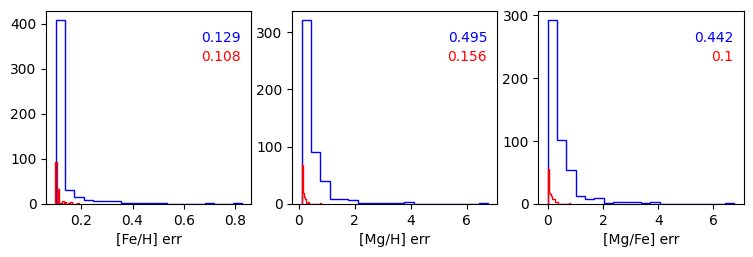

628


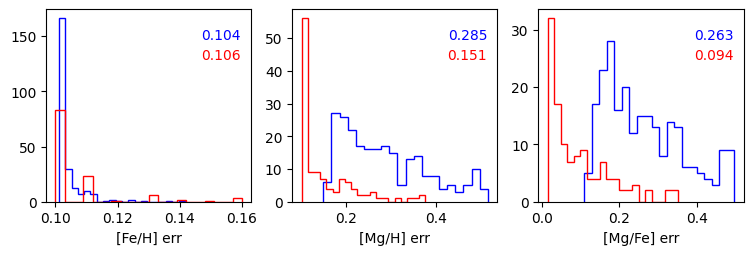

360


In [99]:
final_hsc_fnx_e = final_hsc_fnx[final_hsc_fnx['by'] == 'Evan']
final_hsc_fnx_l = final_hsc_fnx[final_hsc_fnx['by'] == 'Lauren']

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(9,2.5), gridspec_kw={'wspace':0.2})
ax0.hist(final_hsc_fnx_e['FEHERR'], bins=20, color='b', histtype='step')
ax0.hist(final_hsc_fnx_l['FEHERR'], bins=20, color='r', histtype='step')
ax0.set_xlabel('[Fe/H] err')
ax1.hist(final_hsc_fnx_e['MGHERR'], bins=20, color='b', histtype='step')
ax1.hist(final_hsc_fnx_l['MGHERR'], bins=20, color='r', histtype='step')
ax1.set_xlabel('[Mg/H] err')
ax2.hist(final_hsc_fnx_e['MGFEERR'], bins=20, color='b', histtype='step')
ax2.hist(final_hsc_fnx_l['MGFEERR'], bins=20, color='r', histtype='step')
ax2.set_xlabel('[Mg/Fe] err')
ax0.text(0.95, 0.90, f'{np.round(np.mean(final_hsc_fnx_e.FEHERR),3)}', ha='right', va='top', transform=ax0.transAxes, color='b')
ax0.text(0.95, 0.80, f'{np.round(np.mean(final_hsc_fnx_l.FEHERR),3)}', ha='right', va='top', transform=ax0.transAxes, color='r')
ax1.text(0.95, 0.90, f'{np.round(np.mean(final_hsc_fnx_e.MGHERR),3)}', ha='right', va='top', transform=ax1.transAxes, color='b')
ax1.text(0.95, 0.80, f'{np.round(np.mean(final_hsc_fnx_l.MGHERR),3)}', ha='right', va='top', transform=ax1.transAxes, color='r')
ax2.text(0.95, 0.90, f'{np.round(np.mean(final_hsc_fnx_e.MGFEERR),3)}', ha='right', va='top', transform=ax2.transAxes, color='b')
ax2.text(0.95, 0.80, f'{np.round(np.mean(final_hsc_fnx_l.MGFEERR),3)}', ha='right', va='top', transform=ax2.transAxes, color='r')
plt.show()
print(len(final_hsc_fnx_e) + len(final_hsc_fnx_l)) #485

final_hsc_fnx_e = final_hsc_fnx_e[(-0.0 < final_hsc_fnx_e['MGFEERR']) & (final_hsc_fnx_e['MGFEERR'] < 0.5)]
final_hsc_fnx_l = final_hsc_fnx_l[(-0.0 < final_hsc_fnx_l['MGFEERR']) & (final_hsc_fnx_l['MGFEERR'] < 0.5)]
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(9,2.5), gridspec_kw={'wspace':0.2})
ax0.hist(final_hsc_fnx_e['FEHERR'], bins=20, color='b', histtype='step')
ax0.hist(final_hsc_fnx_l['FEHERR'], bins=20, color='r', histtype='step')
ax0.set_xlabel('[Fe/H] err')
ax1.hist(final_hsc_fnx_e['MGHERR'], bins=20, color='b', histtype='step')
ax1.hist(final_hsc_fnx_l['MGHERR'], bins=20, color='r', histtype='step')
ax1.set_xlabel('[Mg/H] err')
ax2.hist(final_hsc_fnx_e['MGFEERR'], bins=20, color='b', histtype='step')
ax2.hist(final_hsc_fnx_l['MGFEERR'], bins=20, color='r', histtype='step')
ax2.set_xlabel('[Mg/Fe] err')
ax0.text(0.95, 0.90, f'{np.round(np.mean(final_hsc_fnx_e.FEHERR),3)}', ha='right', va='top', transform=ax0.transAxes, color='b')
ax0.text(0.95, 0.80, f'{np.round(np.mean(final_hsc_fnx_l.FEHERR),3)}', ha='right', va='top', transform=ax0.transAxes, color='r')
ax1.text(0.95, 0.90, f'{np.round(np.mean(final_hsc_fnx_e.MGHERR),3)}', ha='right', va='top', transform=ax1.transAxes, color='b')
ax1.text(0.95, 0.80, f'{np.round(np.mean(final_hsc_fnx_l.MGHERR),3)}', ha='right', va='top', transform=ax1.transAxes, color='r')
ax2.text(0.95, 0.90, f'{np.round(np.mean(final_hsc_fnx_e.MGFEERR),3)}', ha='right', va='top', transform=ax2.transAxes, color='b')
ax2.text(0.95, 0.80, f'{np.round(np.mean(final_hsc_fnx_l.MGFEERR),3)}', ha='right', va='top', transform=ax2.transAxes, color='r')
plt.show()
print(len(final_hsc_fnx_e) + len(final_hsc_fnx_l)) #308

# Sculptor

In [25]:
## read Subaru HSC cat file
input_catfile = 'hsc_data/sculptor_tpall3e_g24.cat'
df4 = ascii.read(input_catfile,
      names=['id', 'ra', 'dec', 'X', 'Y', 'ipsf', 'gpsf', 'npsf', 'ipsferr',
             'gpsferr', 'npsferr', 'cli', 'clg', 'cln', 'a_i', 'a_g', 'a_n'])
print(len(df4)) #224203
df4 = df4[(df4['cli'] == 0) & (df4['clg'] == 0) & (df4['cln'] == 0)]
print(len(df4)) #54920
df4['id'] = df4['id'].astype(float)
df4['g0'] = df4['gpsf'] - df4['a_g']
df4['i0'] = df4['ipsf'] - df4['a_i']
df4['n0'] = df4['npsf'] - df4['a_n']

224203
54920


In [26]:
## read DEIMOS fits file
input_fitsfile = 'deimos_data/alldsph_moogify.fits'
df5 = Table.read(input_fitsfile, format='fits')
df5 = df5[df5['DSPH'] == 'scl   ']
df5 = df5[['DSPH', 'OBJNAME', 'MASK', 'SLIT', 'RA', 'DEC',
            'B', 'V', 'R', 'I', 'J', 'H', 'K', 'BERR', 'VERR', 'RERR', 'IERR', 'JERR', 'HERR', 'KERR', 'PHOT_COLOR',
            'AGE', 'TEFF', 'TEFFERR', 'LOGG', 'LOGGERR',
            'FEH', 'FEHERR', 'ALPHAFE', 'ALPHAFEERR', 'MGFE', 'MGFEERR', 'SIFE', 'SIFEERR', 'CAFE', 'CAFEERR', 'TIFE', 'TIFEERR']]
df5 = df5.to_pandas()
df5.loc[:,'by'] = 'Evan'
for column in df5.columns:
    if df5[column].dtype == 'object' and isinstance(df5[column][0], bytes):
        df5[column] = df5[column].str.decode('utf-8')
df5 = df5.sort_values(by=['RA'], ascending=True)
print(len(df5)) #376

td0 = df5[df5['RA'] == 15.127875002225242]
print(td0)

bad_ra_values = [15.127875002225242]
bad_df5 = df5[df5['RA'].isin(bad_ra_values)]
good_df5 = df5[~df5['RA'].isin(bad_ra_values)]
print('len(bad_df5) =', len(bad_df5)) #1
print('len(good_df5) =', len(good_df5)) #375

376
       DSPH           OBJNAME     MASK  SLIT         RA        DEC    B  \
354  scl     1016958           scl6       66  15.127875 -33.758917  0.0   

             V    R          I  ...  ALPHAFEERR  MGFE  MGFEERR      SIFE  \
354  18.685323  0.0  17.587128  ...    0.122779  -0.8     -0.0  0.125111   

      SIFEERR      CAFE   CAFEERR      TIFE   TIFEERR    by  
354  0.165751  0.312309  0.212096 -0.214371  0.155632  Evan  

[1 rows x 39 columns]
len(bad_df5) = 1
len(good_df5) = 375


In [27]:
## read DEIMOS Lauren csv file
input_fitsfile = 'Mgabundances_Lauren/third/fulldataAlldSphs.csv'
df6 = pd.read_csv(input_fitsfile)
df6 = df6[['Name','RA','Dec','Galaxy','slitmask','Temp (K)','log(g)',
           '[Fe/H]','err([Fe/H])','[alpha/Fe]','[C/Fe]','[Mg/Fe]','errup([Mg/Fe])','errdown([Mg/Fe])','upper_[Mg/Fe]_twosigma','Mg_upperlimit',
           '[Sr/Fe]','errup([Sr/Fe])','errdown([Sr/Fe])','upper_[Sr/Fe]_twosigma','Sr_upperlimit',
           '[Y/Fe]','errup([Y/Fe])','errdown([Y/Fe])','upper_[Y/Fe]_twosigma','Y_upperlimit',
           '[Ba/Fe]','errup([Ba/Fe])','errdown([Ba/Fe])','upper_[Ba/Fe]_twosigma','Ba_upperlimit',
           '[La/Fe]','errup([La/Fe])','errdown([La/Fe])','upper_[La/Fe]_twosigma','La_upperlimit',
           '[Eu/Fe]','errup([Eu/Fe])','errdown([Eu/Fe])','upper_[Eu/Fe]_twosigma','Eu_upperlimit']]
df6 = df6[df6['Galaxy'] == 'Sculptor']
df6.loc[:,'by'] = 'Lauren'
df6 = df6.sort_values(by=['RA'], ascending=True)
print(len(df6)) #258

td0_l = df6[df6['RA'] == 15.127862501144408]
print(td0_l) #1

bad_ra_values = [15.127862501144408]
bad_df6 = df6[df6['RA'].isin(bad_ra_values)]
good_df6 = df6[~df6['RA'].isin(bad_ra_values)]
print('len(bad_df6) =', len(bad_df6)) #1
print('len(good_df6) =', len(good_df6)) #257

258
        Name         RA        Dec    Galaxy slitmask  Temp (K)  log(g)  \
227  1016958  15.127863 -33.758908  Sculptor    bscl6      4571    1.45   

     [Fe/H]  err([Fe/H])  [alpha/Fe]  ...  errup([La/Fe])  errdown([La/Fe])  \
227   -1.36          0.1       -0.06  ...            0.34              0.32   

     upper_[La/Fe]_twosigma  La_upperlimit  [Eu/Fe]  errup([Eu/Fe])  \
227                     NaN            0.0    -0.42            0.35   

     errdown([Eu/Fe])  upper_[Eu/Fe]_twosigma  Eu_upperlimit      by  
227              2.48                    0.29            1.0  Lauren  

[1 rows x 42 columns]
len(bad_df6) = 1
len(good_df6) = 257


In [28]:
pd.options.mode.copy_on_write = True

df4['coord'] = SkyCoord(df4['ra'], df4['dec'], unit=(u.degree, u.degree))


#df5 = Table.from_pandas(df5)
#df5['coord'] = SkyCoord(df5['RA'], df5['DEC'], unit=(u.degree, u.degree))

bad_df5 = Table.from_pandas(bad_df5)
bad_df5['coord'] = SkyCoord(bad_df5['RA'], bad_df5['DEC'], unit=(u.degree, u.degree))

good_df5 = Table.from_pandas(good_df5)
good_df5['coord'] = SkyCoord(good_df5['RA'], good_df5['DEC'], unit=(u.degree, u.degree))


#df6 = Table.from_pandas(df6)
#df6['coord'] = SkyCoord(df6['RA'], df6['Dec'], unit=(u.degree, u.degree))

bad_df6 = Table.from_pandas(bad_df6)
bad_df6['coord'] = SkyCoord(bad_df6['RA'], bad_df6['Dec'], unit=(u.degree, u.degree))

good_df6 = Table.from_pandas(good_df6)
good_df6['coord'] = SkyCoord(good_df6['RA'], good_df6['Dec'], unit=(u.degree, u.degree))

In [29]:
## match HSC and DEIMOS

#df45 = merge_catalogs(df4, df5, cat_names=['1', '2'], match_radius=1, join_type='outer')
#df45 = df45.to_pandas()
#print('len(df45) =', len(df45)) #377

#The new header has 'header of df1' + 'coord_1.ra, coord_1.dec' + 'deimos header' + 'coord_2.ra, coord_2.dec'
#If the parameter names are same, it is changed, e.g., RA -> RA_1
bad_df45 = merge_catalogs(df4, bad_df5, cat_names=['1', '2'], match_radius=1, join_type='outer')
bad_df45 = bad_df45.to_pandas()
print('len(bad_df45) =', len(bad_df45)) #2
print(bad_df45['cli'])
print(bad_df45['i0'])
bad_df45_rm_dup = bad_df45[bad_df45['cli'] == 0]
print('len(bad_df45_rm_dup) =', len(bad_df45_rm_dup)) #1
print(bad_df45_rm_dup['i0']) #

good_df45 = merge_catalogs(df4, good_df5, cat_names=['1', '2'], match_radius=1, join_type='outer')
good_df45 = good_df45.to_pandas()
print('len(good_df45) =', len(good_df45)) #356

df45 = pd.concat([bad_df45_rm_dup, good_df45], axis=0)
print('len(df45) =', len(df45)) #357

df45 = Table.from_pandas(df45)

df45.write('Sculptor_HSC_DEIMOS.fits', format='fits', overwrite='True')
#df45.to_csv('Sculptor_HSC_DEIMOS.csv', index=False)

len(bad_df45) = 1
0    0.0
Name: cli, dtype: float64
0    18.148507
Name: i0, dtype: float64
len(bad_df45_rm_dup) = 1
0    18.148507
Name: i0, dtype: float64
len(good_df45) = 356
len(df45) = 357


In [30]:
print(Counter(df45['cli']))
print(Counter(df45['clg']))
print(Counter(df45['cln']))

Counter({0.0: 357})
Counter({0.0: 357})
Counter({0.0: 357})


In [31]:
## match HSC and DEIMOS

#df46 = merge_catalogs(df4, df6, cat_names=['1', '2'], match_radius=1, join_type='outer')
#df46 = df46.to_pandas()
#print('len(df46) =', len(df46)) #

#The new header has 'header of df1' + 'coord_1.ra, coord_1.dec' + 'deimos header' + 'coord_2.ra, coord_2.dec'
#If the parameter names are same, it is changed, e.g., RA -> RA_1
bad_df46 = merge_catalogs(df4, bad_df6, cat_names=['1', '2'], match_radius=1, join_type='outer')
bad_df46 = bad_df46.to_pandas()
print('len(bad_df46) =', len(bad_df46)) #1
print(bad_df46['cli'])
print(bad_df46['i0'])
bad_df46_rm_dup = bad_df46[bad_df46['cli'] == 0]
print('len(bad_df46_rm_dup) =', len(bad_df46_rm_dup)) #1
print(bad_df46_rm_dup['i0']) #

good_df46 = merge_catalogs(df4, good_df6, cat_names=['1', '2'], match_radius=1, join_type='outer')
good_df46 = good_df46.to_pandas()
print('len(good_df46) =', len(good_df46)) #241

df46 = pd.concat([bad_df46_rm_dup, good_df46], axis=0)
print('len(df46) =', len(df46)) #242

df46 = Table.from_pandas(df46)

df46.write('Sculptor_HSC_Lauren.fits', format='fits', overwrite='True')
#df46.to_csv('Sculptor_HSC_Lauren.csv', index=False)

len(bad_df46) = 1
0    0.0
Name: cli, dtype: float64
0    18.148507
Name: i0, dtype: float64
len(bad_df46_rm_dup) = 1
0    18.148507
Name: i0, dtype: float64
len(good_df46) = 241
len(df46) = 242


In [32]:
print(Counter(df46['cli']))
print(Counter(df46['clg']))
print(Counter(df46['cln']))

Counter({0.0: 242})
Counter({0.0: 242})
Counter({0.0: 242})


In [33]:
## Sculptor
input_file_name = 'Sculptor_HSC_DEIMOS.fits'
table = Table.read(input_file_name, format='fits')
table['id'] = table['id'].astype(str)
table = table[['DSPH', 'OBJNAME', 'MASK', 'SLIT', 'RA', 'DEC',
              'B', 'V', 'R', 'I', 'J', 'H', 'K', 'BERR', 'VERR', 'RERR', 'IERR', 'JERR', 'HERR', 'KERR', 'PHOT_COLOR',
              'AGE', 'TEFF', 'TEFFERR', 'LOGG', 'LOGGERR',
              'FEH', 'FEHERR', 'ALPHAFE', 'ALPHAFEERR', 'MGFE', 'MGFEERR', 'SIFE', 'SIFEERR', 'CAFE', 'CAFEERR', 'TIFE', 'TIFEERR',
              'id', 'ra', 'dec', 'X', 'Y', 'ipsf', 'gpsf', 'npsf', 'ipsferr', 'gpsferr', 'npsferr', 'cli', 'clg', 'cln', 'a_i', 'a_g', 'a_n','by']]
df_scl_dei = table.to_pandas()
for column in df_scl_dei.columns:
    if df_scl_dei[column].dtype == 'object' and isinstance(df_scl_dei[column][0], bytes):
        df_scl_dei[column] = df_scl_dei[column].str.decode('utf-8')
df_scl_dei['g0'] = df_scl_dei['gpsf'] - df_scl_dei['a_g']
df_scl_dei['i0'] = df_scl_dei['ipsf'] - df_scl_dei['a_i']
df_scl_dei['n0'] = df_scl_dei['npsf'] - df_scl_dei['a_n']
df_scl_dei['MGH'] = df_scl_dei['MGFE'] + df_scl_dei['FEH']
df_scl_dei['MGHERR'] = np.sqrt(df_scl_dei['MGFEERR']**2 + df_scl_dei['FEHERR']**2)
#df_scl_dei = df_scl_dei[-0.0 < df_scl_dei['MGFEERR']]

print('len(df_scl_dei) =', len(df_scl_dei)) #357
#print('len(df_scl_dei MGFEERR == -0.0 =', len(df_scl_dei[df_scl_dei['MGFEERR'] == -0.0])) #
#df_scl_dei = df_scl_dei[-0.0 < df_scl_dei['MGFEERR']]
#print('len(df_scl_dei) =', len(df_scl_dei)) #

len(df_scl_dei) = 357


In [34]:
print(Counter(df_scl_dei['cli']))
print(Counter(df_scl_dei['clg']))
print(Counter(df_scl_dei['cln']))

Counter({0.0: 357})
Counter({0.0: 357})
Counter({0.0: 357})


In [35]:
## Sculptor
import warnings
from astropy.io.fits.verify import VerifyWarning
warnings.filterwarnings('ignore', category=VerifyWarning)

input_file_name = 'Sculptor_HSC_Lauren.fits'
table = Table.read(input_file_name, format='fits')
table = table[['Name', 'RA', 'Dec', 'Temp (K)',
               'log(g)', '[Fe/H]', 'err([Fe/H])', '[alpha/Fe]', '[Mg/Fe]', 'errup([Mg/Fe])', 'errdown([Mg/Fe])',
              'id', 'ra', 'dec', 'X', 'Y', 'ipsf', 'gpsf', 'npsf', 'ipsferr', 'gpsferr', 'npsferr', 'cli', 'clg', 'cln', 'a_i', 'a_g', 'a_n',
              'g0','i0','n0','by']]
df_scl_lau = table.to_pandas()
df_scl_lau['DSPH'] = 'scl'
df_scl_lau.rename(columns={'Name':'OBJNAME', 'Dec':'DEC', 'Temp (K)':'TEFF', 'log(g)':'LOGG',
                           '[Fe/H]':'FEH', 'err([Fe/H])':'FEHERR', '[alpha/Fe]':'ALPHAFE', '[Mg/Fe]':'MGFE'}, inplace=True)
df_scl_lau['MGFEERR'] = (df_scl_lau['errup([Mg/Fe])'] + df_scl_lau['errdown([Mg/Fe])']) / 2.
df_scl_lau.drop(['errup([Mg/Fe])', 'errdown([Mg/Fe])'], axis=1, inplace=True)
df_scl_lau[['MASK','SLIT','B', 'V', 'R', 'I', 'J', 'H', 'K', 'BERR', 'VERR', 'RERR', 'IERR', 'JERR', 'HERR', 'KERR', 'PHOT_COLOR',
            'AGE','TEFFERR','LOGGERR','ALPHAFEERR','SIFE', 'SIFEERR', 'CAFE', 'CAFEERR', 'TIFE', 'TIFEERR']] = np.nan

for column in df_scl_lau.columns:
    if df_scl_lau[column].dtype == 'object' and isinstance(df_scl_lau[column][0], bytes):
        df_scl_lau[column] = df_scl_lau[column].str.decode('utf-8')
df_scl_lau['MGH'] = df_scl_lau['MGFE'] + df_scl_lau['FEH']
df_scl_lau['MGHERR'] = np.sqrt(df_scl_lau['MGFEERR']**2 + df_scl_lau['FEHERR']**2)

df_scl_lau = df_scl_lau[['DSPH', 'OBJNAME', 'MASK', 'SLIT', 'RA', 'DEC',
              'B', 'V', 'R', 'I', 'J', 'H', 'K', 'BERR', 'VERR', 'RERR', 'IERR', 'JERR', 'HERR', 'KERR', 'PHOT_COLOR',
              'AGE', 'TEFF', 'TEFFERR', 'LOGG', 'LOGGERR',
              'FEH', 'FEHERR', 'ALPHAFE', 'ALPHAFEERR', 'MGFE', 'MGFEERR', 'MGH', 'MGHERR', 'SIFE', 'SIFEERR', 'CAFE', 'CAFEERR', 'TIFE', 'TIFEERR',
              'id', 'ra', 'dec', 'X', 'Y', 'ipsf', 'gpsf', 'npsf', 'ipsferr', 'gpsferr', 'npsferr', 'cli', 'clg', 'cln', 'a_i', 'a_g', 'a_n',
              'g0','i0','n0','by']]

print('len(df_scl_lau) =', len(df_scl_lau)) #242

len(df_scl_lau) = 242


In [36]:
print(Counter(df_scl_lau['cli']))
print(Counter(df_scl_lau['clg']))
print(Counter(df_scl_lau['cln']))

Counter({0.0: 242})
Counter({0.0: 242})
Counter({0.0: 242})


In [37]:
print(Counter(df_scl_dei['DSPH']))
print(Counter(df_scl_lau['DSPH']))

Counter({'scl': 357})
Counter({'scl': 242})


In [38]:
df_scl = pd.concat([df_scl_dei, df_scl_lau], axis=0)
print(df_scl) #599

    DSPH  OBJNAME  MASK  SLIT         RA        DEC    B          V    R  \
0    scl  1016958  scl6  66.0  15.127875 -33.758917  0.0  18.685323  0.0   
1    scl  1021100  scl3  82.0  15.207458 -33.738306  0.0  18.860200  0.0   
2    scl  1021185  scl3  84.0  15.209083 -33.733806  0.0  20.189800  0.0   
3    scl  1020549  scl3  80.0  15.199292 -33.684194  0.0  18.186800  0.0   
4    scl  1017802  scl6  73.0  15.143000 -33.831278  0.0  17.766345  0.0   
..   ...      ...   ...   ...        ...        ...  ...        ...  ...   
237  scl  1005651   NaN   NaN  14.912233 -33.603761  NaN        NaN  NaN   
238  scl  1004448   NaN   NaN  14.886571 -33.603031  NaN        NaN  NaN   
239  scl  1003967   NaN   NaN  14.876837 -33.601372  NaN        NaN  NaN   
240  scl  1005457   NaN   NaN  14.908825 -33.585533  NaN        NaN  NaN   
241  scl  1002447   NaN   NaN  14.840254 -33.683781  NaN        NaN  NaN   

             I  ...  cln     a_i     a_g     a_n      by         g0  \
0    17.587128  

In [39]:
df_scl = df_scl.drop_duplicates(subset=['id'], keep='first') #keep the first one among dups
print(len(df_scl)) #599

599


In [40]:
test = df_scl[(df_scl['gpsferr'] != np.inf) & (df_scl['ipsferr'] != np.inf) & (df_scl['npsferr'] != np.inf)]
print(len(test)) #599

599


In [41]:
print(df_scl.columns.values)

['DSPH' 'OBJNAME' 'MASK' 'SLIT' 'RA' 'DEC' 'B' 'V' 'R' 'I' 'J' 'H' 'K'
 'BERR' 'VERR' 'RERR' 'IERR' 'JERR' 'HERR' 'KERR' 'PHOT_COLOR' 'AGE'
 'TEFF' 'TEFFERR' 'LOGG' 'LOGGERR' 'FEH' 'FEHERR' 'ALPHAFE' 'ALPHAFEERR'
 'MGFE' 'MGFEERR' 'SIFE' 'SIFEERR' 'CAFE' 'CAFEERR' 'TIFE' 'TIFEERR' 'id'
 'ra' 'dec' 'X' 'Y' 'ipsf' 'gpsf' 'npsf' 'ipsferr' 'gpsferr' 'npsferr'
 'cli' 'clg' 'cln' 'a_i' 'a_g' 'a_n' 'by' 'g0' 'i0' 'n0' 'MGH' 'MGHERR']


In [42]:
df_scl.to_csv('Sculptor_HSC_Evan_Lauren_before_pm.csv', index=False)

In [43]:
"""
# Plots of mag err
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(10,3), gridspec_kw={'wspace':0.3})

ax0.hist(df_scl['gpsferr'], bins=2, histtype='step', linestyle='solid', color='k')
ax0.set_xlim([-0.01, 0.15])
ax0.set_xlabel('Err_g$_{0}$', size=12)
ax0.set_ylabel('Numbers', size=12)
ax0.axvline(0.02, 0, 40000, color='blue', linestyle='-', alpha=0.5)
ax1.hist(df_scl['npsferr'], bins=2, histtype='step', linestyle='solid', color='k')
ax1.set_xlim([-0.01, 0.15])
ax1.set_xlabel('Err_n$_{0}$', size=12)
ax1.set_ylabel('Numbers', size=12)
ax1.axvline(0.02, 0, 40000, color='blue', linestyle='-', alpha=0.5)
ax2.hist(df_scl['ipsferr'], bins=2, histtype='step', linestyle='solid', color='k')
ax2.set_xlim([-0.01, 0.15])
ax2.set_xlabel('Err_i$_{0}$', size=12)
ax2.set_ylabel('Numbers', size=12)
ax2.axvline(0.02, 0, 40000, color='blue', linestyle='-', alpha=0.5)
plt.show()
"""
# Apply the magnitude err
df_scl_mag_err = df_scl[(df_scl['gpsferr'] < 0.02) & (df_scl['ipsferr'] < 0.02) & (df_scl['npsferr'] < 0.02)]
print(f'After class cut, \ndf_scl_mag_err = {len(df_scl_mag_err)}') #599

After class cut, 
df_scl_mag_err = 599


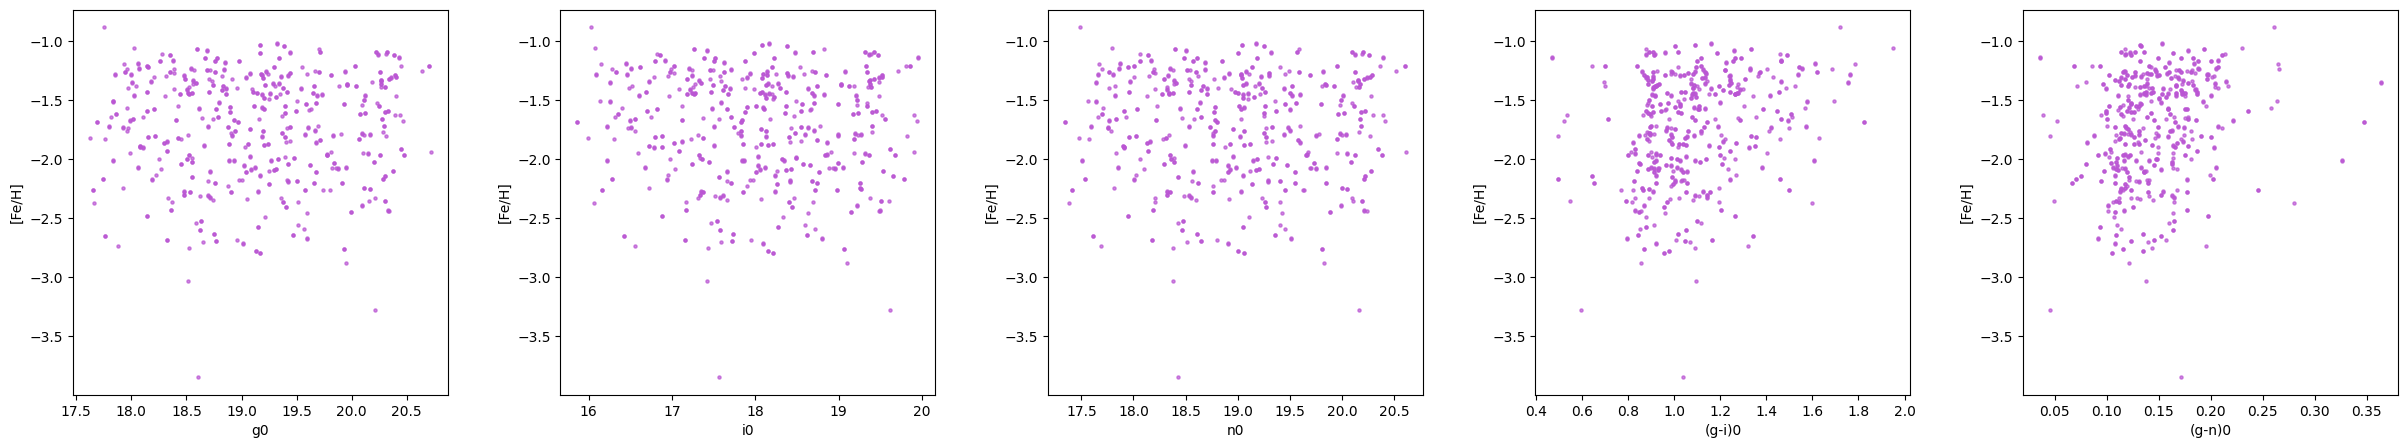

In [44]:
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=5, figsize=(30,5), gridspec_kw={'wspace':0.3})

ax0.scatter(df_scl['g0'], df_scl['FEH'], s=5, color='mediumorchid', alpha=.7)
ax0.set_xlabel('g0')
ax0.set_ylabel('[Fe/H]')

ax1.scatter(df_scl['i0'], df_scl['FEH'], s=5, color='mediumorchid', alpha=.7)
ax1.set_xlabel('i0')
ax1.set_ylabel('[Fe/H]')

ax2.scatter(df_scl['n0'], df_scl['FEH'], s=5, color='mediumorchid', alpha=.7)
ax2.set_xlabel('n0')
ax2.set_ylabel('[Fe/H]')

ax3.scatter(df_scl['g0']-df_scl['i0'], df_scl['FEH'], s=5, color='mediumorchid', alpha=.7)
ax3.set_xlabel('(g-i)0')
ax3.set_ylabel('[Fe/H]')

ax4.scatter(df_scl['g0']-df_scl['n0'], df_scl['FEH'], s=5, color='mediumorchid', alpha=.7)
ax4.set_xlabel('(g-n)0')
ax4.set_ylabel('[Fe/H]')

#plt.show()
plt.savefig('DEIMOS_non_linear_relationships_Sculptor.png', bbox_inches='tight')

len(df2_gaia) = 599
len(df2_gaia_sc) = 599
len(df2_gaia_sc_magerr) = 599
len(df2_gaia_sc_magerr_availpm) = 599
len(df2_gaia_sc_magerr_nonpm) = 0
clipped mean pmRA pmDE = 0.091 -0.151
clipped std pmRA pmDE = 0.075 0.062
r_a, r_b = 0.225 0.186
len(filtered data) = 599
len(inside the ellipse) = 416
len(filtered_df2_gaia_sc_magerr_availpm_nonpm) = 599
len(df2_gaia_sc_magerr_availpm_inside_polygon) = 599


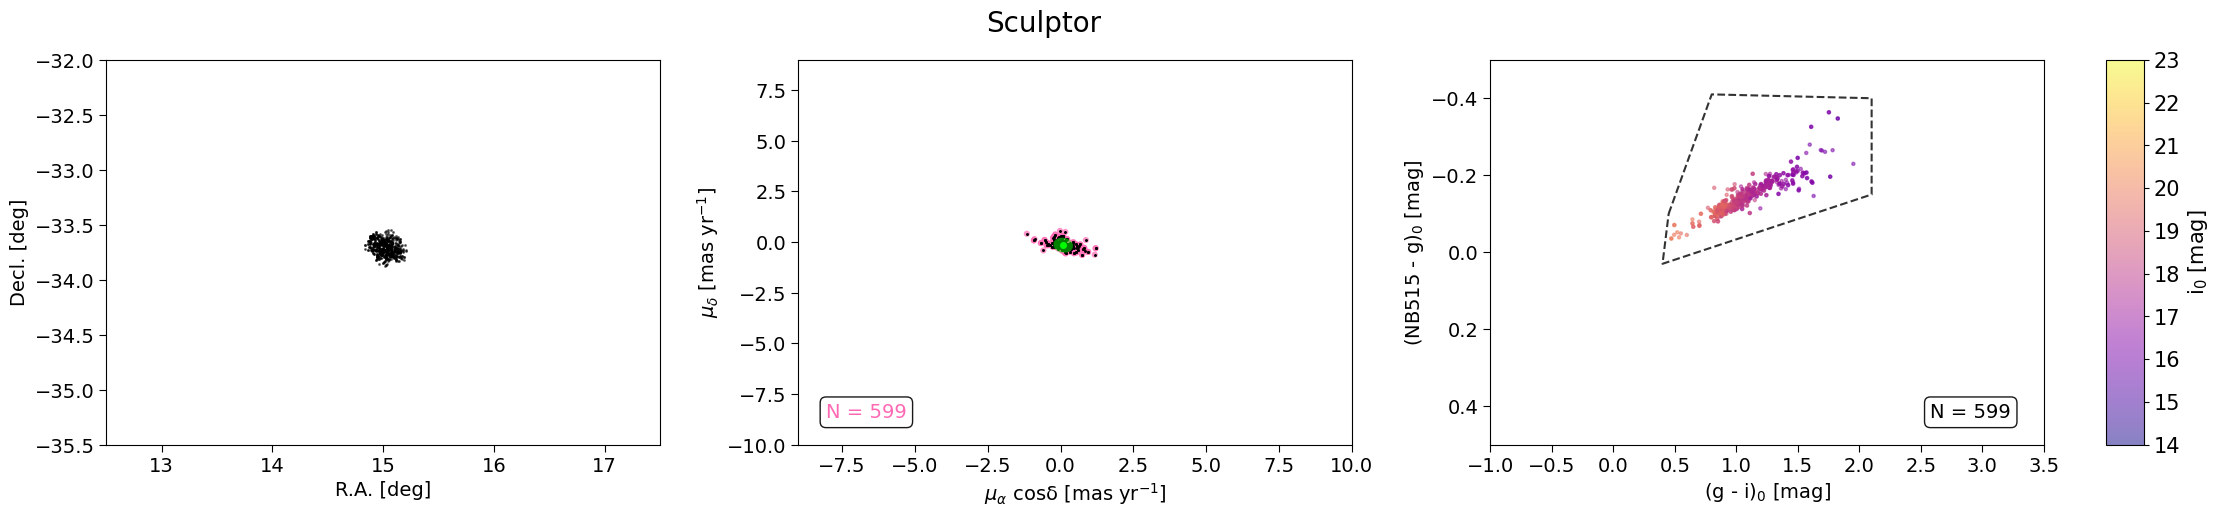

In [108]:
# Test the sample with Gaia DR3
df2_gaia = pd.read_csv('Sculptor_HSC_Evan_Lauren_after_pm.csv')
print(f'len(df2_gaia) = {len(df2_gaia)}') #599
df2_gaia_sc = df2_gaia[(df2_gaia['cli'] == 0) & (df2_gaia['clg'] == 0) & (df2_gaia['cln'] == 0)]
print(f'len(df2_gaia_sc) = {len(df2_gaia_sc)}') #599
df2_gaia_sc_magerr = df2_gaia_sc[(df2_gaia_sc['gpsferr'] < 0.02) & (df2_gaia_sc['ipsferr'] < 0.02) & (df2_gaia_sc['npsferr'] < 0.02)]
print(f'len(df2_gaia_sc_magerr) = {len(df2_gaia_sc_magerr)}') #599
df2_gaia_sc_magerr_availpm = df2_gaia_sc_magerr[df2_gaia_sc_magerr['pmRA'].notnull()]
print('len(df2_gaia_sc_magerr_availpm) =', len(df2_gaia_sc_magerr_availpm)) #599
df2_gaia_sc_magerr_nonpm = df2_gaia_sc_magerr[df2_gaia_sc_magerr['pmRA'].isnull()]
print('len(df2_gaia_sc_magerr_nonpm) =', len(df2_gaia_sc_magerr_nonpm)) #0


# Left
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(25, 5), gridspec_kw={'wspace':0.25})
fig.suptitle('Sculptor', size=20, y=0.98)
alpha = .5 ; s = 5
axs[0].scatter(df2_gaia_sc_magerr_availpm['ra'], df2_gaia_sc_magerr_availpm['dec'], marker='.', s=s, color='k', alpha=.5)
axs[0].set_xlabel('R.A. [deg]', size=14)
axs[0].set_ylabel('Decl. [deg]', size=14)
axs[0].set_xlim([12.5, 17.5])
axs[0].set_ylim([-35.5, -32])
axs[0].tick_params(axis='x', which='major', direction='out', right=False, top=False, length=5, labelsize=14)
axs[0].tick_params(axis='x', which='minor', direction='out', right=False, top=False, length=3, labelsize=14)
axs[0].tick_params(axis='y', which='major', direction='out', right=False, top=False, length=5, labelsize=14)
axs[0].tick_params(axis='y', which='minor', direction='out', right=False, top=False, length=3, labelsize=14)


# Middle
#pmra_0, pmdec_0 = 0.082, -0.133 # McConnachie et al. 2020
#r_a, r_b = 1.3, 0.9 # manually / std of pmRA pmDE = 12.22 10.46
pmRA = df2_gaia_sc_magerr_availpm['pmRA']
pmDE = df2_gaia_sc_magerr_availpm['pmDE']
err_pmra = df2_gaia_sc_magerr_availpm['e_pmRA']
err_pmdec = df2_gaia_sc_magerr_availpm['e_pmDE']
err_pm = np.sqrt(err_pmra**2 + err_pmdec**2)
# Sigma Clipping
clipped_pmRA = sigma_clip(pmRA, sigma=2, maxiters=10, stdfunc=np.std)
clipped_pmDE = sigma_clip(pmDE, sigma=2, maxiters=10, stdfunc=np.std)
mean_pmRA = np.round(np.mean(clipped_pmRA), 3)
mean_pmDE = np.round(np.mean(clipped_pmDE), 3)
std_pmRA = np.round(np.std(clipped_pmRA), 3)
std_pmDE = np.round(np.std(clipped_pmDE), 3)
print('clipped mean pmRA pmDE =', mean_pmRA, mean_pmDE) #0.126 -0.144
print('clipped std pmRA pmDE =', std_pmRA, std_pmDE) #0.415 0.303
pmra_0, pmdec_0 = mean_pmRA, mean_pmDE
r_a, r_b = np.round(std_pmRA * 3, 3), np.round(std_pmDE * 3, 3)
print('r_a, r_b =', r_a, r_b) #1.245 0.909
axs[1].plot(pmra_0, pmdec_0, marker='o', markersize=4, color='lime')
ellipse = Ellipse(xy=[pmra_0, pmdec_0], width=r_a*2, height=r_b*2, angle=150, edgecolor='lime', fc='None', lw=5, alpha=0.5)
axs[1].add_patch(ellipse)
angle = ellipse.angle

def within_ellipse(x, y, x_0, y_0, r_a, r_b):
    theta = np.radians(360 - angle)
    x_rot = x * np.cos(theta) - y * np.sin(theta)
    y_rot = x * np.sin(theta) + y * np.cos(theta)
    x_0_rot = x_0 * np.cos(theta) - y_0 * np.sin(theta)
    y_0_rot = x_0 * np.sin(theta) + y_0 * np.cos(theta)
    return ( (r_b * (x_rot - x_0_rot))**2 + (r_a * (y_rot - y_0_rot))**2 ) <= (r_a * r_b)**2

def within_ellipse_w_errpm(x, y, x_0, y_0, r_a, r_b, err_pm):
    theta = np.radians(360 - angle)
    x_rot = x * np.cos(theta) - y * np.sin(theta)
    y_rot = x * np.sin(theta) + y * np.cos(theta)
    x_0_rot = x_0 * np.cos(theta) - y_0 * np.sin(theta)
    y_0_rot = x_0 * np.sin(theta) + y_0 * np.cos(theta)
    return ( (r_b * (x_rot - x_0_rot))**2 + (r_a * (y_rot - y_0_rot))**2 ) <= (r_a * r_b)**2 + (3 * err_pm)**2

theta = np.radians(360 - angle)

mask = df2_gaia_sc_magerr_availpm.apply(lambda row: within_ellipse_w_errpm(row['pmRA'], row['pmDE'], pmra_0, pmdec_0, r_a, r_b, np.sqrt(row['e_pmRA']**2 + row['e_pmDE']**2)), axis=1)
filtered_df2_gaia_sc_magerr_availpm = df2_gaia_sc_magerr_availpm[mask]
print('len(filtered data) =', len(filtered_df2_gaia_sc_magerr_availpm)) #599
axs[1].scatter(filtered_df2_gaia_sc_magerr_availpm['pmRA'], filtered_df2_gaia_sc_magerr_availpm['pmDE'], marker='o', s=20, facecolor='hotpink', edgecolor='none', alpha=0.7)
props = dict(boxstyle='round', facecolor='white', alpha=0.9)
axs[1].text(0.05, 0.07, 'N = {}'.format(len(filtered_df2_gaia_sc_magerr_availpm)), transform=axs[1].transAxes, fontsize=14, color='hotpink', bbox=props)

axs[1].scatter(df2_gaia_sc_magerr_availpm['pmRA'], df2_gaia_sc_magerr_availpm['pmDE'], marker='.', s=s, color='k', alpha=1)
axs[1].set_xlabel('$\mu_{\\alpha}~\mathrm{cos\delta}$ [mas yr$^{-1}$]', size=14)
axs[1].set_ylabel('$\mu_{\delta}$ [mas yr$^{-1}$]', size=14)
axs[1].set_xlim([-9, 10])
axs[1].set_ylim([-10, 9])
axs[1].add_patch(ellipse)
axs[1].tick_params(axis='x', which='major', direction='out', right=False, top=False, length=5, labelsize=14)
axs[1].tick_params(axis='x', which='minor', direction='out', right=False, top=False, length=3, labelsize=14)
axs[1].tick_params(axis='y', which='major', direction='out', right=False, top=False, length=5, labelsize=14)
axs[1].tick_params(axis='y', which='minor', direction='out', right=False, top=False, length=3, labelsize=14)

mask_test = df2_gaia_sc_magerr_availpm.apply(lambda row: within_ellipse(row['pmRA'], row['pmDE'], pmra_0, pmdec_0, r_a, r_b), axis=1)
inside_ellipse_test = df2_gaia_sc_magerr_availpm[mask_test]
print('len(inside the ellipse) =', len(inside_ellipse_test)) #416

filtered_df2_gaia_sc_magerr_availpm_nonpm = pd.concat([df2_gaia_sc_magerr_nonpm, filtered_df2_gaia_sc_magerr_availpm], axis=0)
print('len(filtered_df2_gaia_sc_magerr_availpm_nonpm) =', len(filtered_df2_gaia_sc_magerr_availpm_nonpm)) #599


# Right
cax = fig.add_axes([axs[2].get_position().x1+0.025, axs[2].get_position().y0, 0.015, axs[2].get_position().height])
img = axs[2].scatter(filtered_df2_gaia_sc_magerr_availpm['g0'] - filtered_df2_gaia_sc_magerr_availpm['i0'], 
                     filtered_df2_gaia_sc_magerr_availpm['n0'] - filtered_df2_gaia_sc_magerr_availpm['g0'], 
                     marker='o', s=s, c=filtered_df2_gaia_sc_magerr_availpm['i0'], cmap='plasma', alpha=alpha)
axs[2].set_xlim([-1, 3.5])
axs[2].set_ylim([0.5, -0.5])
axs[2].set_xlabel('(g - i)$_{0}$ [mag]', size=14)
axs[2].set_ylabel('(NB515 - g)$_{0}$ [mag]', size=14)
axs[2].tick_params(axis='x', which='major', direction='out', right=False, top=False, length=5, labelsize=14)
axs[2].tick_params(axis='x', which='minor', direction='out', right=False, top=False, length=3, labelsize=14)
axs[2].tick_params(axis='y', which='major', direction='out', right=False, top=False, length=5, labelsize=14)
axs[2].tick_params(axis='y', which='minor', direction='out', right=False, top=False, length=3, labelsize=14)
cbar = plt.colorbar(img, cax=cax)
cbar.ax.tick_params(labelsize=15)
cbar.set_label('i$_{0}$ [mag]', size=15)
cbar.mappable.set_clim(vmin=14, vmax=23)
cbar.update_ticks()
coord = [[0.45, -0.1], [0.8, -0.41], [2.1, -0.4], [2.1, -0.15], [0.4, 0.03], [0.45, -0.1]]
xs, ys = zip(*coord)
axs[2].plot(xs, ys, linestyle='--', linewidth=1.5, alpha=.8, color='k')
polygon = Path(coord)
points = np.vstack((filtered_df2_gaia_sc_magerr_availpm['g0'] - filtered_df2_gaia_sc_magerr_availpm['i0'], 
                    filtered_df2_gaia_sc_magerr_availpm['n0'] - filtered_df2_gaia_sc_magerr_availpm['g0'])).T
inside = polygon.contains_points(points)
df2_gaia_sc_magerr_availpm_inside_polygon = filtered_df2_gaia_sc_magerr_availpm[inside]
props = dict(boxstyle='round', facecolor='white', alpha=0.9)
axs[2].text(0.795, 0.07, 'N = {}'.format(len(df2_gaia_sc_magerr_availpm_inside_polygon)), transform=axs[2].transAxes, fontsize=14, color='black', bbox=props)
print('len(df2_gaia_sc_magerr_availpm_inside_polygon) =', len(df2_gaia_sc_magerr_availpm_inside_polygon)) #599

#plt.show()
plt.savefig('DEIMOS_ccd_select_sample_Sculptor_pm.png', bbox_inches='tight')

In [109]:
final_hsc_scl = df2_gaia_sc_magerr_availpm_inside_polygon
print(f'len(final_hsc_scl) = {len(final_hsc_scl)}') #599
final_hsc_scl.to_csv('Sculptor_DEIMOS_Evan_Lauren.csv', index=False)

len(final_hsc_scl) = 599


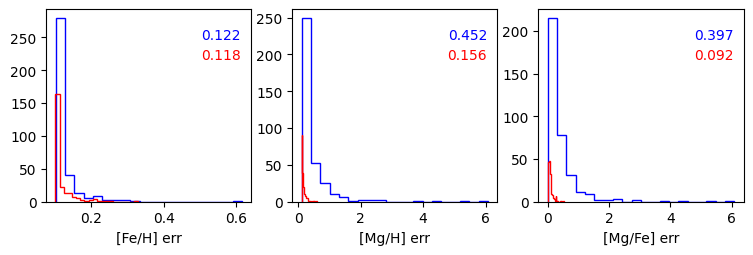

599


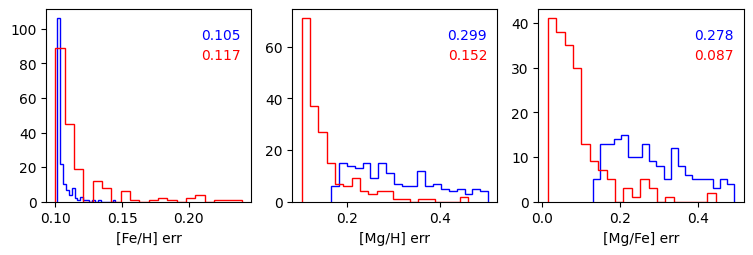

361


In [110]:
final_hsc_scl_e = final_hsc_scl[final_hsc_scl['by'] == 'Evan']
final_hsc_scl_l = final_hsc_scl[final_hsc_scl['by'] == 'Lauren']

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(9,2.5), gridspec_kw={'wspace':0.2})
ax0.hist(final_hsc_scl_e['FEHERR'], bins=20, color='b', histtype='step')
ax0.hist(final_hsc_scl_l['FEHERR'], bins=20, color='r', histtype='step')
ax0.set_xlabel('[Fe/H] err')
ax1.hist(final_hsc_scl_e['MGHERR'], bins=20, color='b', histtype='step')
ax1.hist(final_hsc_scl_l['MGHERR'], bins=20, color='r', histtype='step')
ax1.set_xlabel('[Mg/H] err')
ax2.hist(final_hsc_scl_e['MGFEERR'], bins=20, color='b', histtype='step')
ax2.hist(final_hsc_scl_l['MGFEERR'], bins=20, color='r', histtype='step')
ax2.set_xlabel('[Mg/Fe] err')
ax0.text(0.95, 0.90, f'{np.round(np.mean(final_hsc_scl_e.FEHERR),3)}', ha='right', va='top', transform=ax0.transAxes, color='b')
ax0.text(0.95, 0.80, f'{np.round(np.mean(final_hsc_scl_l.FEHERR),3)}', ha='right', va='top', transform=ax0.transAxes, color='r')
ax1.text(0.95, 0.90, f'{np.round(np.mean(final_hsc_scl_e.MGHERR),3)}', ha='right', va='top', transform=ax1.transAxes, color='b')
ax1.text(0.95, 0.80, f'{np.round(np.mean(final_hsc_scl_l.MGHERR),3)}', ha='right', va='top', transform=ax1.transAxes, color='r')
ax2.text(0.95, 0.90, f'{np.round(np.mean(final_hsc_scl_e.MGFEERR),3)}', ha='right', va='top', transform=ax2.transAxes, color='b')
ax2.text(0.95, 0.80, f'{np.round(np.mean(final_hsc_scl_l.MGFEERR),3)}', ha='right', va='top', transform=ax2.transAxes, color='r')
plt.show()
print(len(final_hsc_scl_e) + len(final_hsc_scl_l)) #405

final_hsc_scl_e = final_hsc_scl_e[(-0.0 < final_hsc_scl_e['MGFEERR']) & (final_hsc_scl_e['MGFEERR'] < 0.5)]
final_hsc_scl_l = final_hsc_scl_l[(-0.0 < final_hsc_scl_l['MGFEERR']) & (final_hsc_scl_l['MGFEERR'] < 0.5)]
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(9,2.5), gridspec_kw={'wspace':0.2})
ax0.hist(final_hsc_scl_e['FEHERR'], bins=20, color='b', histtype='step')
ax0.hist(final_hsc_scl_l['FEHERR'], bins=20, color='r', histtype='step')
ax0.set_xlabel('[Fe/H] err')
ax1.hist(final_hsc_scl_e['MGHERR'], bins=20, color='b', histtype='step')
ax1.hist(final_hsc_scl_l['MGHERR'], bins=20, color='r', histtype='step')
ax1.set_xlabel('[Mg/H] err')
ax2.hist(final_hsc_scl_e['MGFEERR'], bins=20, color='b', histtype='step')
ax2.hist(final_hsc_scl_l['MGFEERR'], bins=20, color='r', histtype='step')
ax2.set_xlabel('[Mg/Fe] err')
ax0.text(0.95, 0.90, f'{np.round(np.mean(final_hsc_scl_e.FEHERR),3)}', ha='right', va='top', transform=ax0.transAxes, color='b')
ax0.text(0.95, 0.80, f'{np.round(np.mean(final_hsc_scl_l.FEHERR),3)}', ha='right', va='top', transform=ax0.transAxes, color='r')
ax1.text(0.95, 0.90, f'{np.round(np.mean(final_hsc_scl_e.MGHERR),3)}', ha='right', va='top', transform=ax1.transAxes, color='b')
ax1.text(0.95, 0.80, f'{np.round(np.mean(final_hsc_scl_l.MGHERR),3)}', ha='right', va='top', transform=ax1.transAxes, color='r')
ax2.text(0.95, 0.90, f'{np.round(np.mean(final_hsc_scl_e.MGFEERR),3)}', ha='right', va='top', transform=ax2.transAxes, color='b')
ax2.text(0.95, 0.80, f'{np.round(np.mean(final_hsc_scl_l.MGFEERR),3)}', ha='right', va='top', transform=ax2.transAxes, color='r')
plt.show()
print(len(final_hsc_scl_e) + len(final_hsc_scl_l)) #283

# Ursa Minor

In [48]:
## read Subaru HSC cat file
input_catfile = 'hsc_data/ursaminor_tpall3e_g24.cat'
df7 = ascii.read(input_catfile,
      names=['id', 'ra', 'dec', 'X', 'Y', 'ipsf', 'gpsf', 'npsf', 'ipsferr',
             'gpsferr', 'npsferr', 'cli', 'clg', 'cln', 'a_i', 'a_g', 'a_n'])
print(len(df7)) #135112
df7 = df7[(df7['cli'] == 0) & (df7['clg'] == 0) & (df7['cln'] == 0)]
print(len(df7)) #41894
df7['id'] = df7['id'].astype(float)
df7['g0'] = df7['gpsf'] - df7['a_g']
df7['i0'] = df7['ipsf'] - df7['a_i']
df7['n0'] = df7['npsf'] - df7['a_n']

135112
41894


In [49]:
## read DEIMOS fits file
input_fitsfile = 'deimos_data/alldsph_moogify.fits'
df8 = Table.read(input_fitsfile, format='fits')
df8 = df8[df8['DSPH'] == 'umi   ']
df8 = df8[['DSPH', 'OBJNAME', 'MASK', 'SLIT', 'RA', 'DEC',
            'B', 'V', 'R', 'I', 'J', 'H', 'K', 'BERR', 'VERR', 'RERR', 'IERR', 'JERR', 'HERR', 'KERR', 'PHOT_COLOR',
            'AGE', 'TEFF', 'TEFFERR', 'LOGG', 'LOGGERR',
            'FEH', 'FEHERR', 'ALPHAFE', 'ALPHAFEERR', 'MGFE', 'MGFEERR', 'SIFE', 'SIFEERR', 'CAFE', 'CAFEERR', 'TIFE', 'TIFEERR']]
df8 = df8.to_pandas()
df8.loc[:,'by'] = 'Evan'
for column in df8.columns:
    if df8[column].dtype == 'object' and isinstance(df8[column][0], bytes):
        df8[column] = df8[column].str.decode('utf-8')
df8 = df8.sort_values(by=['RA'], ascending=True)
print(len(df8)) #540

tn0 = df8[df8['RA'] == 226.6808329993642]
tn1 = df8[df8['RA'] == 227.18874999682106]
tn2 = df8[df8['RA'] == 227.22591667175294]
tn3 = df8[df8['RA'] == 227.41370833714802]
tn4 = df8[df8['RA'] == 227.75372771]
tn5 = df8[df8['RA'] == 227.85120667]
tn6 = df8[df8['RA'] == 228.30138224]
print(tn0)
print(tn1)
print(tn2)
print(tn3)
print(tn4)
print(tn5)
print(tn6)

bad_ra_values = [226.6808329993642, 227.18874999682106, 227.22591667175294, 227.41370833714802, 227.75372771, 227.85120667, 228.30138224]
bad_df8 = df8[df8['RA'].isin(bad_ra_values)]
good_df8 = df8[~df8['RA'].isin(bad_ra_values)]
print('len(bad_df8) =', len(bad_df8)) #7
print('len(good_df8) =', len(good_df8)) #533

540
       DSPH           OBJNAME     MASK  SLIT          RA        DEC    B  \
530  umi     p12145            uss-12     37  226.680833  67.153443  0.0   

             V    R      I  ...  ALPHAFEERR      MGFE   MGFEERR      SIFE  \
530  16.695999  0.0  15.27  ...    0.085368  0.046524  0.272957  0.203238   

      SIFEERR      CAFE   CAFEERR      TIFE  TIFEERR    by  
530  0.109256  0.118683  0.115583  0.017309  0.10707  Evan  

[1 rows x 39 columns]
       DSPH           OBJNAME     MASK  SLIT         RA        DEC    B  \
126  umi     Pal10020          umi3       25  227.18875  67.193806  0.0   

             V    R          I  ...  ALPHAFEERR      MGFE  MGFEERR      SIFE  \
126  18.831743  0.0  17.935655  ...    0.224736  0.525168  0.46578 -0.119133   

      SIFEERR      CAFE   CAFEERR      TIFE   TIFEERR    by  
126  0.371693 -0.136622  0.251471  0.067843  0.215149  Evan  

[1 rows x 39 columns]
       DSPH           OBJNAME     MASK  SLIT          RA        DEC    B  \
143  umi

In [50]:
## read DEIMOS Lauren csv file
input_fitsfile = 'Mgabundances_Lauren/third/fulldataAlldSphs.csv'
df9 = pd.read_csv(input_fitsfile)
df9 = df9[['Name','RA','Dec','Galaxy','slitmask','Temp (K)','log(g)',
           '[Fe/H]','err([Fe/H])','[alpha/Fe]','[C/Fe]','[Mg/Fe]','errup([Mg/Fe])','errdown([Mg/Fe])','upper_[Mg/Fe]_twosigma','Mg_upperlimit',
           '[Sr/Fe]','errup([Sr/Fe])','errdown([Sr/Fe])','upper_[Sr/Fe]_twosigma','Sr_upperlimit',
           '[Y/Fe]','errup([Y/Fe])','errdown([Y/Fe])','upper_[Y/Fe]_twosigma','Y_upperlimit',
           '[Ba/Fe]','errup([Ba/Fe])','errdown([Ba/Fe])','upper_[Ba/Fe]_twosigma','Ba_upperlimit',
           '[La/Fe]','errup([La/Fe])','errdown([La/Fe])','upper_[La/Fe]_twosigma','La_upperlimit',
           '[Eu/Fe]','errup([Eu/Fe])','errdown([Eu/Fe])','upper_[Eu/Fe]_twosigma','Eu_upperlimit']]
df9 = df9[df9['Galaxy'] == 'Ursa Minor']
df9.loc[:,'by'] = 'Lauren'
df9 = df9.sort_values(by=['RA'], ascending=True)
print(len(df9)) #96

tn0_l = df9[df9['RA'] == 227.18874999682103]
tn1_l = df9[df9['RA'] == 227.413708337148]
print(tn0_l)
print(tn1_l)

bad_ra_values = [227.18874999682103, 227.413708337148]
bad_df9 = df9[df9['RA'].isin(bad_ra_values)]
good_df9 = df9[~df9['RA'].isin(bad_ra_values)]
print('len(bad_df9) =', len(bad_df9)) #2
print('len(good_df9) =', len(good_df9)) #94

96
         Name         RA        Dec      Galaxy slitmask  Temp (K)  log(g)  \
702  Pal10020  227.18875  67.193806  Ursa Minor    bumi3      4917    1.88   

     [Fe/H]  err([Fe/H])  [alpha/Fe]  ...  errup([La/Fe])  errdown([La/Fe])  \
702   -0.99          0.1       -0.27  ...             NaN               NaN   

     upper_[La/Fe]_twosigma  La_upperlimit  [Eu/Fe]  errup([Eu/Fe])  \
702                     NaN            NaN      NaN             NaN   

     errdown([Eu/Fe])  upper_[Eu/Fe]_twosigma  Eu_upperlimit      by  
702               NaN                     NaN            NaN  Lauren  

[1 rows x 42 columns]
       Name          RA        Dec      Galaxy slitmask  Temp (K)  log(g)  \
701  Pal157  227.413708  67.356333  Ursa Minor    bumi3      4763    1.35   

     [Fe/H]  err([Fe/H])  [alpha/Fe]  ...  errup([La/Fe])  errdown([La/Fe])  \
701   -2.04         0.11       -0.09  ...            0.22              0.41   

     upper_[La/Fe]_twosigma  La_upperlimit  [Eu/Fe]  errup(

In [51]:
pd.options.mode.copy_on_write = True

df7['coord'] = SkyCoord(df7['ra'], df7['dec'], unit=(u.degree, u.degree))


#df8 = Table.from_pandas(df8)
#df8['coord'] = SkyCoord(df8['RA'], df8['DEC'], unit=(u.degree, u.degree))

bad_df8 = Table.from_pandas(bad_df8)
bad_df8['coord'] = SkyCoord(bad_df8['RA'], bad_df8['DEC'], unit=(u.degree, u.degree))

good_df8 = Table.from_pandas(good_df8)
good_df8['coord'] = SkyCoord(good_df8['RA'], good_df8['DEC'], unit=(u.degree, u.degree))


#df9 = Table.from_pandas(df9)
#df9['coord'] = SkyCoord(df9['RA'], df9['Dec'], unit=(u.degree, u.degree))

bad_df9 = Table.from_pandas(bad_df9)
bad_df9['coord'] = SkyCoord(bad_df9['RA'], bad_df9['Dec'], unit=(u.degree, u.degree))

good_df9 = Table.from_pandas(good_df9)
good_df9['coord'] = SkyCoord(good_df9['RA'], good_df9['Dec'], unit=(u.degree, u.degree))

In [52]:
## match HSC and DEIMOS

#df78 = merge_catalogs(df7, df8, cat_names=['1', '2'], match_radius=1, join_type='outer')
#df78 = df78.to_pandas()
#print('len(df78) =', len(df78)) #

#The new header has 'header of df1' + 'coord_1.ra, coord_1.dec' + 'deimos header' + 'coord_2.ra, coord_2.dec'
#If the parameter names are same, it is changed, e.g., RA -> RA_1
#bad_df78 = merge_catalogs(df7, bad_df8, cat_names=['1', '2'], match_radius=1, join_type='outer')
#bad_df78 = bad_df78.to_pandas()
#print('len(bad_df78) =', len(bad_df78)) #
#bad_df78_rm_dup = bad_df78.iloc[[0]]
#print(bad_df78_rm_dup) #

good_df78 = merge_catalogs(df7, good_df8, cat_names=['1', '2'], match_radius=1, join_type='outer')
good_df78 = good_df78.to_pandas()
print('len(good_df78) =', len(good_df78)) #456

#df78 = pd.concat([bad_df78_rm_dup, good_df78], axis=0)
df78 = good_df78
print('len(df78) =', len(df78)) #456

df78 = Table.from_pandas(df78)

df78.write('Ursaminor_HSC_DEIMOS.fits', format='fits', overwrite='True')
#df78.to_csv('Ursaminor_HSC_DEIMOS.csv', index=False)

len(good_df78) = 456
len(df78) = 456


In [53]:
print(Counter(df78['cli']))
print(Counter(df78['clg']))
print(Counter(df78['cln']))

Counter({0.0: 456})
Counter({0.0: 456})
Counter({0.0: 456})


In [54]:
## match HSC and DEIMOS

#df79 = merge_catalogs(df7, df9, cat_names=['1', '2'], match_radius=1, join_type='outer')
#df79 = df79.to_pandas()
#print('len(df79) =', len(df79)) #

#The new header has 'header of df1' + 'coord_1.ra, coord_1.dec' + 'deimos header' + 'coord_2.ra, coord_2.dec'
#If the parameter names are same, it is changed, e.g., RA -> RA_1
#bad_df79 = merge_catalogs(df7, bad_df9, cat_names=['1', '2'], match_radius=1, join_type='outer')
#bad_df79 = bad_df79.to_pandas()
#print('len(bad_df79) =', len(bad_df79)) #
#print(bad_df79['cli'], bad_df46['i0'])
#bad_df79_rm_dup = bad_df46.iloc[[0]]
#print(bad_df79_rm_dup) #

good_df79 = merge_catalogs(df7, good_df9, cat_names=['1', '2'], match_radius=1, join_type='outer')
good_df79 = good_df79.to_pandas()
print('len(good_df79) =', len(good_df79)) #78

#df79 = pd.concat([bad_df79_rm_dup, good_df79], axis=0)
df79 = good_df79
print('len(df79) =', len(df79)) #78

df79 = Table.from_pandas(df79)

df79.write('Ursaminor_HSC_Lauren.fits', format='fits', overwrite='True')
#df79.to_csv('Ursaminor_HSC_Lauren.csv', index=False)

len(good_df79) = 78
len(df79) = 78


In [55]:
print(Counter(df79['cli']))
print(Counter(df79['clg']))
print(Counter(df79['cln']))

Counter({0.0: 78})
Counter({0.0: 78})
Counter({0.0: 78})


In [56]:
## Ursa Minor
input_file_name = 'Ursaminor_HSC_DEIMOS.fits'
table = Table.read(input_file_name, format='fits')
table['id'] = table['id'].astype(str)
table = table[['DSPH', 'OBJNAME', 'MASK', 'SLIT', 'RA', 'DEC',
              'B', 'V', 'R', 'I', 'J', 'H', 'K', 'BERR', 'VERR', 'RERR', 'IERR', 'JERR', 'HERR', 'KERR', 'PHOT_COLOR',
              'AGE', 'TEFF', 'TEFFERR', 'LOGG', 'LOGGERR',
              'FEH', 'FEHERR', 'ALPHAFE', 'ALPHAFEERR', 'MGFE', 'MGFEERR', 'SIFE', 'SIFEERR', 'CAFE', 'CAFEERR', 'TIFE', 'TIFEERR',
              'id', 'ra', 'dec', 'X', 'Y', 'ipsf', 'gpsf', 'npsf', 'ipsferr', 'gpsferr', 'npsferr', 'cli', 'clg', 'cln', 'a_i', 'a_g', 'a_n','by']]
df_umi_dei = table.to_pandas()
for column in df_umi_dei.columns:
    if df_umi_dei[column].dtype == 'object' and isinstance(df_umi_dei[column][0], bytes):
        df_umi_dei[column] = df_umi_dei[column].str.decode('utf-8')
df_umi_dei['g0'] = df_umi_dei['gpsf'] - df_umi_dei['a_g']
df_umi_dei['i0'] = df_umi_dei['ipsf'] - df_umi_dei['a_i']
df_umi_dei['n0'] = df_umi_dei['npsf'] - df_umi_dei['a_n']
df_umi_dei['MGH'] = df_umi_dei['MGFE'] + df_umi_dei['FEH']
df_umi_dei['MGHERR'] = np.sqrt(df_umi_dei['MGFEERR']**2 + df_umi_dei['FEHERR']**2)
#df_umi = df_umi[(0 < df_umi['FEHERR']) & (df_umi['FEHERR'] < 0.3) & (0 < df_umi['MGFEERR']) & (df_umi['MGFEERR'] < 0.3)]
#df_umi_dei = df_umi_dei[-0.0 < df_umi_dei['MGFEERR']]

print('len(df_umi_dei) =', len(df_umi_dei)) #456
#print('len(df_umi_dei MGFEERR == -0.0 =', len(df_umi_dei[df_umi_dei['MGFEERR'] == -0.0])) #
#df_umi_dei = df_umi_dei[-0.0 < df_umi_dei['MGFEERR']]
#print('len(df_umi_dei) =', len(df_umi_dei)) #

len(df_umi_dei) = 456


In [57]:
print(Counter(df_umi_dei['cli']))
print(Counter(df_umi_dei['clg']))
print(Counter(df_umi_dei['cln']))

Counter({0.0: 456})
Counter({0.0: 456})
Counter({0.0: 456})


In [58]:
## Ursaminor
import warnings
from astropy.io.fits.verify import VerifyWarning
warnings.filterwarnings('ignore', category=VerifyWarning)

input_file_name = 'Ursaminor_HSC_Lauren.fits'
table = Table.read(input_file_name, format='fits')
table = table[['Name', 'RA', 'Dec', 'Temp (K)',
               'log(g)', '[Fe/H]', 'err([Fe/H])', '[alpha/Fe]', '[Mg/Fe]', 'errup([Mg/Fe])', 'errdown([Mg/Fe])',
              'id', 'ra', 'dec', 'X', 'Y', 'ipsf', 'gpsf', 'npsf', 'ipsferr', 'gpsferr', 'npsferr', 'cli', 'clg', 'cln', 'a_i', 'a_g', 'a_n',
              'g0','i0','n0','by']]
df_umi_lau = table.to_pandas()
df_umi_lau['DSPH'] = 'umi'
df_umi_lau.rename(columns={'Name':'OBJNAME', 'Dec':'DEC', 'Temp (K)':'TEFF', 'log(g)':'LOGG',
                           '[Fe/H]':'FEH', 'err([Fe/H])':'FEHERR', '[alpha/Fe]':'ALPHAFE', '[Mg/Fe]':'MGFE'}, inplace=True)
df_umi_lau['MGFEERR'] = (df_umi_lau['errup([Mg/Fe])'] + df_umi_lau['errdown([Mg/Fe])']) / 2.
df_umi_lau.drop(['errup([Mg/Fe])', 'errdown([Mg/Fe])'], axis=1, inplace=True)
df_umi_lau[['MASK','SLIT','B', 'V', 'R', 'I', 'J', 'H', 'K', 'BERR', 'VERR', 'RERR', 'IERR', 'JERR', 'HERR', 'KERR', 'PHOT_COLOR',
            'AGE','TEFFERR','LOGGERR','ALPHAFEERR','SIFE', 'SIFEERR', 'CAFE', 'CAFEERR', 'TIFE', 'TIFEERR']] = np.nan

for column in df_umi_lau.columns:
    if df_umi_lau[column].dtype == 'object' and isinstance(df_umi_lau[column][0], bytes):
        df_umi_lau[column] = df_umi_lau[column].str.decode('utf-8')
df_umi_lau['MGH'] = df_umi_lau['MGFE'] + df_umi_lau['FEH']
df_umi_lau['MGHERR'] = np.sqrt(df_umi_lau['MGFEERR']**2 + df_umi_lau['FEHERR']**2)

df_umi_lau = df_umi_lau[['DSPH', 'OBJNAME', 'MASK', 'SLIT', 'RA', 'DEC',
              'B', 'V', 'R', 'I', 'J', 'H', 'K', 'BERR', 'VERR', 'RERR', 'IERR', 'JERR', 'HERR', 'KERR', 'PHOT_COLOR',
              'AGE', 'TEFF', 'TEFFERR', 'LOGG', 'LOGGERR',
              'FEH', 'FEHERR', 'ALPHAFE', 'ALPHAFEERR', 'MGFE', 'MGFEERR', 'MGH', 'MGHERR', 'SIFE', 'SIFEERR', 'CAFE', 'CAFEERR', 'TIFE', 'TIFEERR',
              'id', 'ra', 'dec', 'X', 'Y', 'ipsf', 'gpsf', 'npsf', 'ipsferr', 'gpsferr', 'npsferr', 'cli', 'clg', 'cln', 'a_i', 'a_g', 'a_n',
              'g0','i0','n0','by']]

print('len(df_umi_lau) =', len(df_umi_lau)) #78

len(df_umi_lau) = 78


In [59]:
print(Counter(df_umi_lau['cli']))
print(Counter(df_umi_lau['clg']))
print(Counter(df_umi_lau['cln']))

Counter({0.0: 78})
Counter({0.0: 78})
Counter({0.0: 78})


In [60]:
print(Counter(df_umi_dei['DSPH']))
print(Counter(df_umi_lau['DSPH']))

Counter({'umi': 456})
Counter({'umi': 78})


In [61]:
df_umi = pd.concat([df_umi_dei, df_umi_lau], axis=0)
print(df_umi) #534

   DSPH           OBJNAME   MASK  SLIT          RA        DEC    B          V  \
0   umi          s4893811  uss-1  37.0  227.649754  67.187606  0.0  21.045000   
1   umi          s4892598  uss-1  28.0  227.725988  67.197233  0.0  21.384001   
2   umi          s4893876  uss-1  39.0  227.764839  67.222758  0.0  20.865000   
3   umi          Bel20829   umi1  49.0  227.523583  67.236507  0.0  20.573629   
4   umi          Bel20836   umi1  65.0  227.509350  67.240212  0.0  21.148867   
..  ...               ...    ...   ...         ...        ...  ...        ...   
73  umi          Bel10130    NaN   NaN  227.128708  67.182994  NaN        NaN   
74  umi          Bel60021    NaN   NaN  226.961983  67.186931  NaN        NaN   
75  umi          Bel60230    NaN   NaN  226.999058  67.258008  NaN        NaN   
76  umi  5880213375336454    NaN   NaN  226.998046  67.074106  NaN        NaN   
77  umi  5880213375336450    NaN   NaN  227.001954  67.090297  NaN        NaN   

      R          I  ...  cl

In [62]:
df_umi = df_umi.drop_duplicates(subset=['id'], keep='first') #keep the first one among dups
print(len(df_umi)) #525

525


In [63]:
test = df_umi[(df_umi['gpsferr'] != np.inf) & (df_umi['ipsferr'] != np.inf) & (df_umi['npsferr'] != np.inf)]
print(len(test)) #525

525


In [64]:
print(df_umi.columns.values)

['DSPH' 'OBJNAME' 'MASK' 'SLIT' 'RA' 'DEC' 'B' 'V' 'R' 'I' 'J' 'H' 'K'
 'BERR' 'VERR' 'RERR' 'IERR' 'JERR' 'HERR' 'KERR' 'PHOT_COLOR' 'AGE'
 'TEFF' 'TEFFERR' 'LOGG' 'LOGGERR' 'FEH' 'FEHERR' 'ALPHAFE' 'ALPHAFEERR'
 'MGFE' 'MGFEERR' 'SIFE' 'SIFEERR' 'CAFE' 'CAFEERR' 'TIFE' 'TIFEERR' 'id'
 'ra' 'dec' 'X' 'Y' 'ipsf' 'gpsf' 'npsf' 'ipsferr' 'gpsferr' 'npsferr'
 'cli' 'clg' 'cln' 'a_i' 'a_g' 'a_n' 'by' 'g0' 'i0' 'n0' 'MGH' 'MGHERR']


In [65]:
df_umi.to_csv('Ursaminor_HSC_Evan_Lauren_before_pm.csv', index=False)

In [66]:
"""
# Plots of mag err
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(10,3), gridspec_kw={'wspace':0.3})

ax0.hist(df_umi['gpsferr'], bins=2, histtype='step', linestyle='solid', color='k')
ax0.set_xlim([-0.01, 0.15])
ax0.set_xlabel('Err_g$_{0}$', size=12)
ax0.set_ylabel('Numbers', size=12)
ax0.axvline(0.02, 0, 40000, color='blue', linestyle='-', alpha=0.5)
ax1.hist(df_umi['npsferr'], bins=2, histtype='step', linestyle='solid', color='k')
ax1.set_xlim([-0.01, 0.15])
ax1.set_xlabel('Err_n$_{0}$', size=12)
ax1.set_ylabel('Numbers', size=12)
ax1.axvline(0.02, 0, 40000, color='blue', linestyle='-', alpha=0.5)
ax2.hist(df_umi['ipsferr'], bins=2, histtype='step', linestyle='solid', color='k')
ax2.set_xlim([-0.01, 0.15])
ax2.set_xlabel('Err_i$_{0}$', size=12)
ax2.set_ylabel('Numbers', size=12)
ax2.axvline(0.02, 0, 40000, color='blue', linestyle='-', alpha=0.5)
plt.show()
"""
# Apply the magnitude err
df_umi_mag_err = df_umi[(df_umi['gpsferr'] < 0.02) & (df_umi['ipsferr'] < 0.02) & (df_umi['npsferr'] < 0.02)]
print(f'After class cut, \ndf_umi_mag_err = {len(df_umi_mag_err)}') #525

After class cut, 
df_umi_mag_err = 525


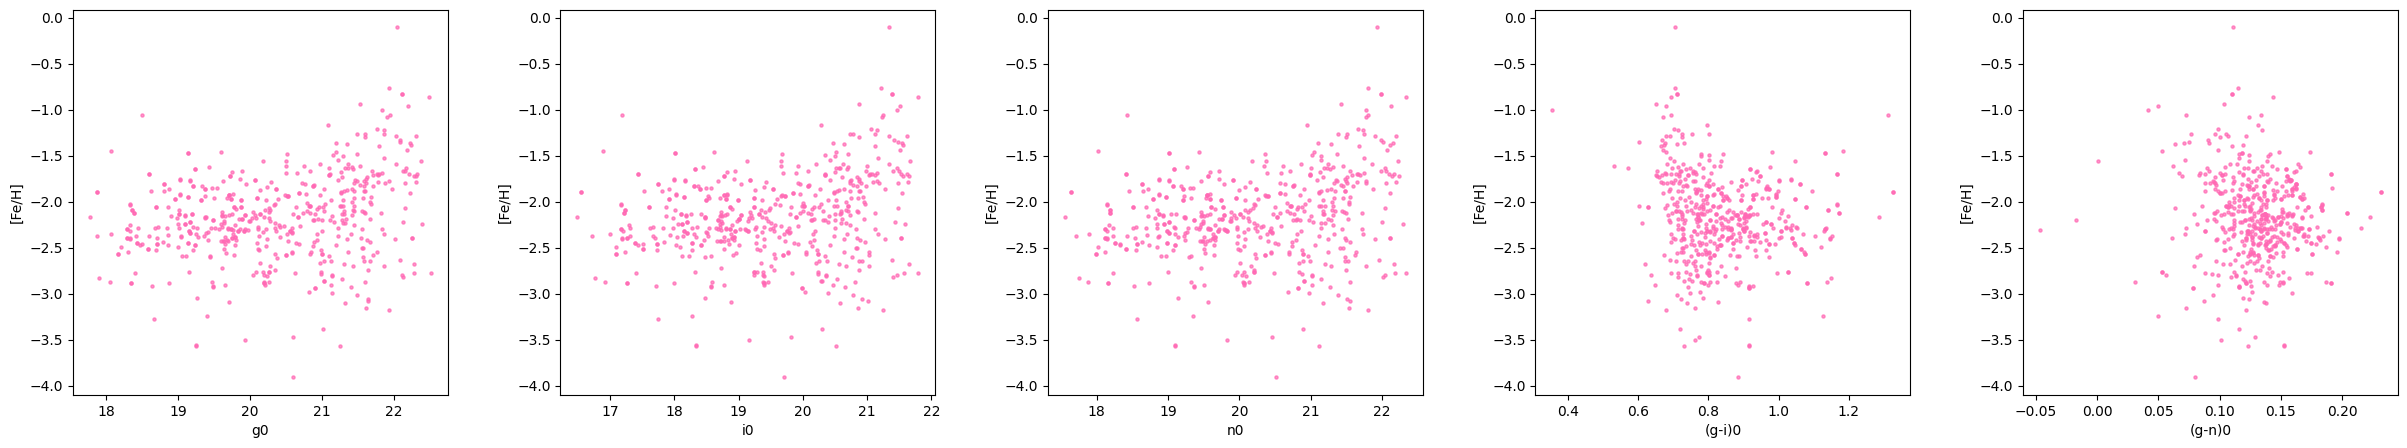

In [67]:
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=5, figsize=(30,5), gridspec_kw={'wspace':0.3})

ax0.scatter(df_umi['g0'], df_umi['FEH'], s=5, color='hotpink', alpha=.7)
ax0.set_xlabel('g0')
ax0.set_ylabel('[Fe/H]')

ax1.scatter(df_umi['i0'], df_umi['FEH'], s=5, color='hotpink', alpha=.7)
ax1.set_xlabel('i0')
ax1.set_ylabel('[Fe/H]')

ax2.scatter(df_umi['n0'], df_umi['FEH'], s=5, color='hotpink', alpha=.7)
ax2.set_xlabel('n0')
ax2.set_ylabel('[Fe/H]')

ax3.scatter(df_umi['g0']-df_umi['i0'], df_umi['FEH'], s=5, color='hotpink', alpha=.7)
ax3.set_xlabel('(g-i)0')
ax3.set_ylabel('[Fe/H]')

ax4.scatter(df_umi['g0']-df_umi['n0'], df_umi['FEH'], s=5, color='hotpink', alpha=.7)
ax4.set_xlabel('(g-n)0')
ax4.set_ylabel('[Fe/H]')

#plt.show()
plt.savefig('DEIMOS_non_linear_relationships_Ursaminor.png', bbox_inches='tight')

len(df3_gaia) = 525
len(df3_gaia_sc) = 525
len(df3_gaia_sc_magerr) = 525
len(df3_gaia_sc_magerr_availpm) = 390
len(df3_gaia_sc_magerr_nonpm) = 135
clipped mean pmRA pmDE = -0.135 0.063
clipped std pmRA pmDE = 0.023 0.037
r_a, r_b = 0.069 0.111
len(filtered data) = 390
len(inside the ellipse) = 36
len(filtered_df3_gaia_sc_magerr_availpm_nonpm) = 525
len(df3_gaia_sc_magerr_availpm_inside_polygon) = 384


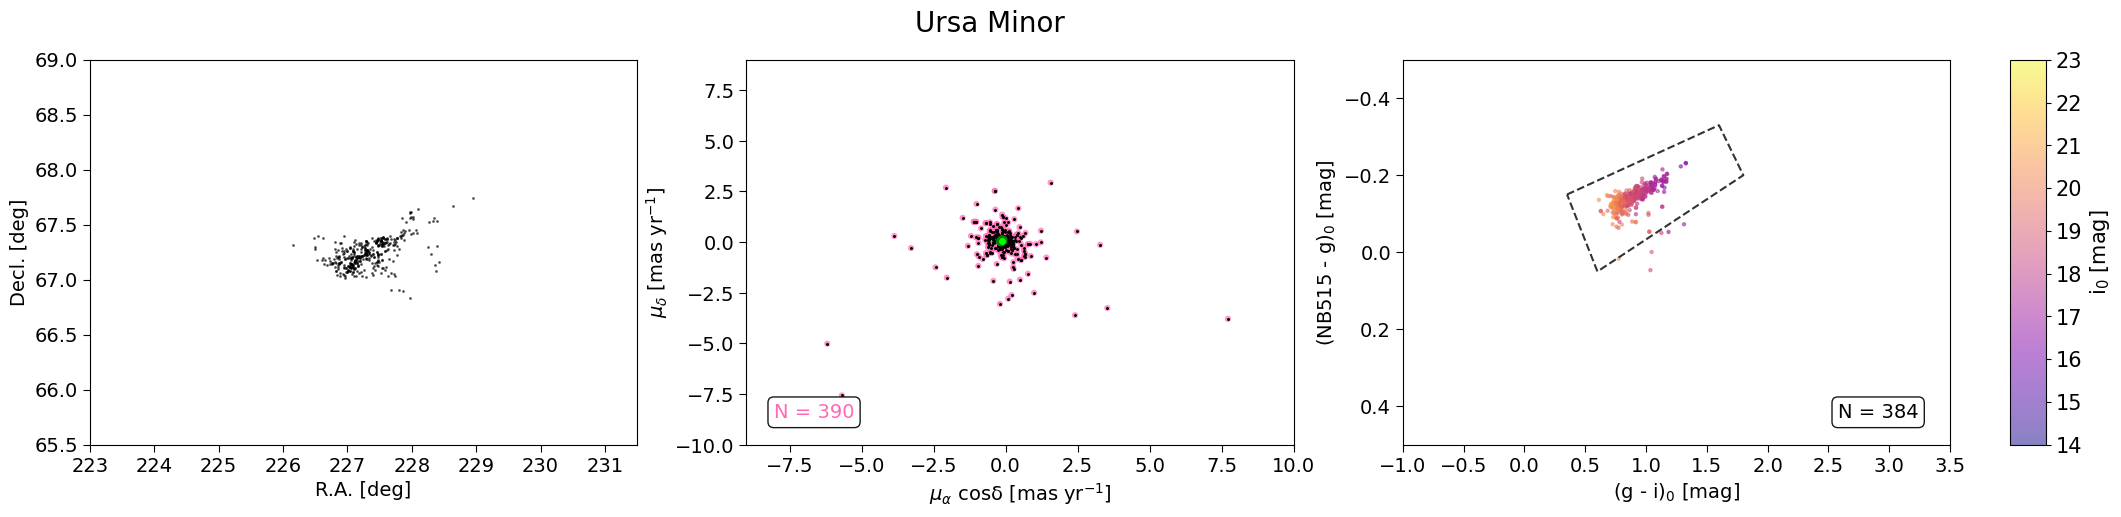

In [115]:
# Test the sample with Gaia DR3
df3_gaia = pd.read_csv('Ursaminor_HSC_Evan_Lauren_after_pm.csv')
print(f'len(df3_gaia) = {len(df3_gaia)}') #525
df3_gaia_sc = df3_gaia[(df3_gaia['cli'] == 0) & (df3_gaia['clg'] == 0) & (df3_gaia['cln'] == 0)]
print(f'len(df3_gaia_sc) = {len(df3_gaia_sc)}') #525
df3_gaia_sc_magerr = df3_gaia_sc[(df3_gaia_sc['gpsferr'] < 0.02) & (df3_gaia_sc['ipsferr'] < 0.02) & (df3_gaia_sc['npsferr'] < 0.02)]
print(f'len(df3_gaia_sc_magerr) = {len(df3_gaia_sc_magerr)}') #525
df3_gaia_sc_magerr_availpm = df3_gaia_sc_magerr[df3_gaia_sc_magerr['pmRA'].notnull()]
print('len(df3_gaia_sc_magerr_availpm) =', len(df3_gaia_sc_magerr_availpm)) #390
df3_gaia_sc_magerr_nonpm = df3_gaia_sc_magerr[df3_gaia_sc_magerr['pmRA'].isnull()]
print('len(df3_gaia_sc_magerr_nonpm) =', len(df3_gaia_sc_magerr_nonpm)) #135


# Left
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(24, 5), gridspec_kw={'wspace':0.2})
fig.suptitle('Ursa Minor', size=20, y=0.98)
alpha = .5 ; s = 5
axs[0].scatter(df3_gaia_sc_magerr_availpm['ra'], df3_gaia_sc_magerr_availpm['dec'], marker='.', s=s, color='k', alpha=.5)
axs[0].set_xlabel('R.A. [deg]', size=14)
axs[0].set_ylabel('Decl. [deg]', size=14)
axs[0].set_xlim([223, 231.5])
axs[0].set_ylim([65.5, 69])
axs[0].tick_params(axis='x', which='major', direction='out', right=False, top=False, length=5, labelsize=14)
axs[0].tick_params(axis='x', which='minor', direction='out', right=False, top=False, length=3, labelsize=14)
axs[0].tick_params(axis='y', which='major', direction='out', right=False, top=False, length=5, labelsize=14)
axs[0].tick_params(axis='y', which='minor', direction='out', right=False, top=False, length=3, labelsize=14)


# Middle
#pmra_0, pmdec_0 = -0.16, 0.06 # McConnachie et al. 2020
#r_a, r_b = 0.9, 0.9 # manually / std of pmRA pmDE = 12.22 10.46
pmRA = df3_gaia_sc_magerr_availpm['pmRA']
pmDE = df3_gaia_sc_magerr_availpm['pmDE']
err_pmra = df3_gaia_sc_magerr_availpm['e_pmRA']
err_pmdec = df3_gaia_sc_magerr_availpm['e_pmDE']
err_pm = np.sqrt(err_pmra**2 + err_pmdec**2)
# Sigma Clipping
clipped_pmRA = sigma_clip(pmRA, sigma=1.5, maxiters=10, stdfunc=np.std)
clipped_pmDE = sigma_clip(pmDE, sigma=1.5, maxiters=10, stdfunc=np.std)
mean_pmRA = np.round(np.mean(clipped_pmRA), 3)
mean_pmDE = np.round(np.mean(clipped_pmDE), 3)
std_pmRA = np.round(np.std(clipped_pmRA), 3)
std_pmDE = np.round(np.std(clipped_pmDE), 3)
print('clipped mean pmRA pmDE =', mean_pmRA, mean_pmDE) #-0.139 -0.013
print('clipped std pmRA pmDE =', std_pmRA, std_pmDE) #0.311 0.322
pmra_0, pmdec_0 = mean_pmRA, mean_pmDE
r_a, r_b = np.round(std_pmRA * 3, 3), np.round(std_pmDE * 3, 3)
print('r_a, r_b =', r_a, r_b) #0.933 0.966
axs[1].plot(pmra_0, pmdec_0, marker='o', markersize=4, color='lime')
ellipse = Ellipse(xy=[pmra_0, pmdec_0], width=r_a*2, height=r_b*2, angle=150, edgecolor='lime', fc='None', lw=5, alpha=0.5)
axs[1].add_patch(ellipse)
angle = ellipse.angle

def within_ellipse(x, y, x_0, y_0, r_a, r_b):
    theta = np.radians(360 - angle)
    x_rot = x * np.cos(theta) - y * np.sin(theta)
    y_rot = x * np.sin(theta) + y * np.cos(theta)
    x_0_rot = x_0 * np.cos(theta) - y_0 * np.sin(theta)
    y_0_rot = x_0 * np.sin(theta) + y_0 * np.cos(theta)
    return ( (r_b * (x_rot - x_0_rot))**2 + (r_a * (y_rot - y_0_rot))**2 ) <= (r_a * r_b)**2

def within_ellipse_w_errpm(x, y, x_0, y_0, r_a, r_b, err_pm):
    theta = np.radians(360 - angle)
    x_rot = x * np.cos(theta) - y * np.sin(theta)
    y_rot = x * np.sin(theta) + y * np.cos(theta)
    x_0_rot = x_0 * np.cos(theta) - y_0 * np.sin(theta)
    y_0_rot = x_0 * np.sin(theta) + y_0 * np.cos(theta)
    return ( (r_b * (x_rot - x_0_rot))**2 + (r_a * (y_rot - y_0_rot))**2 ) <= (r_a * r_b)**2 + (3 * err_pm)**2

theta = np.radians(360 - angle)

mask = df3_gaia_sc_magerr_availpm.apply(lambda row: within_ellipse_w_errpm(row['pmRA'], row['pmDE'], pmra_0, pmdec_0, r_a, r_b, np.sqrt(row['e_pmRA']**2 + row['e_pmDE']**2)), axis=1)
filtered_df3_gaia_sc_magerr_availpm = df3_gaia_sc_magerr_availpm[mask]
print('len(filtered data) =', len(filtered_df3_gaia_sc_magerr_availpm)) #390
axs[1].scatter(filtered_df3_gaia_sc_magerr_availpm['pmRA'], filtered_df3_gaia_sc_magerr_availpm['pmDE'], marker='o', s=20, facecolor='hotpink', edgecolor='none', alpha=0.7)
props = dict(boxstyle='round', facecolor='white', alpha=0.9)
axs[1].text(0.05, 0.07, 'N = {}'.format(len(filtered_df3_gaia_sc_magerr_availpm)), transform=axs[1].transAxes, fontsize=14, color='hotpink', bbox=props)

axs[1].scatter(df3_gaia_sc_magerr_availpm['pmRA'], df3_gaia_sc_magerr_availpm['pmDE'], marker='.', s=s, color='k', alpha=1)
axs[1].set_xlabel('$\mu_{\\alpha}~\mathrm{cos\delta}$ [mas yr$^{-1}$]', size=14)
axs[1].set_ylabel('$\mu_{\delta}$ [mas yr$^{-1}$]', size=14)
axs[1].set_xlim([-9, 10])
axs[1].set_ylim([-10, 9])
axs[1].add_patch(ellipse)
axs[1].tick_params(axis='x', which='major', direction='out', right=False, top=False, length=5, labelsize=14)
axs[1].tick_params(axis='x', which='minor', direction='out', right=False, top=False, length=3, labelsize=14)
axs[1].tick_params(axis='y', which='major', direction='out', right=False, top=False, length=5, labelsize=14)
axs[1].tick_params(axis='y', which='minor', direction='out', right=False, top=False, length=3, labelsize=14)

mask_test = df3_gaia_sc_magerr_availpm.apply(lambda row: within_ellipse(row['pmRA'], row['pmDE'], pmra_0, pmdec_0, r_a, r_b), axis=1)
inside_ellipse_test = df3_gaia_sc_magerr_availpm[mask_test]
print('len(inside the ellipse) =', len(inside_ellipse_test)) #36

filtered_df3_gaia_sc_magerr_availpm_nonpm = pd.concat([df3_gaia_sc_magerr_nonpm, filtered_df3_gaia_sc_magerr_availpm], axis=0)
print('len(filtered_df3_gaia_sc_magerr_availpm_nonpm) =', len(filtered_df3_gaia_sc_magerr_availpm_nonpm)) #525


# Right
cax = fig.add_axes([axs[2].get_position().x1+0.025, axs[2].get_position().y0, 0.015, axs[2].get_position().height])
img = axs[2].scatter(filtered_df3_gaia_sc_magerr_availpm['g0'] - filtered_df3_gaia_sc_magerr_availpm['i0'], 
                     filtered_df3_gaia_sc_magerr_availpm['n0'] - filtered_df3_gaia_sc_magerr_availpm['g0'], 
                     marker='o', s=s, c=filtered_df3_gaia_sc_magerr_availpm['i0'], cmap='plasma', alpha=alpha)
axs[2].set_xlim([-1, 3.5])
axs[2].set_ylim([0.5, -0.5])
axs[2].set_xlabel('(g - i)$_{0}$ [mag]', size=14)
axs[2].set_ylabel('(NB515 - g)$_{0}$ [mag]', size=14)
axs[2].tick_params(axis='x', which='major', direction='out', right=False, top=False, length=5, labelsize=14)
axs[2].tick_params(axis='x', which='minor', direction='out', right=False, top=False, length=3, labelsize=14)
axs[2].tick_params(axis='y', which='major', direction='out', right=False, top=False, length=5, labelsize=14)
axs[2].tick_params(axis='y', which='minor', direction='out', right=False, top=False, length=3, labelsize=14)
cbar = plt.colorbar(img, cax=cax)
cbar.ax.tick_params(labelsize=15)
cbar.set_label('i$_{0}$ [mag]', size=15)
cbar.mappable.set_clim(vmin=14, vmax=23)
cbar.update_ticks()
coord = [[0.35, -0.15], [1.6, -0.33], [1.8, -0.2], [0.6, 0.05], [0.35, -0.15]]
xs, ys = zip(*coord)
axs[2].plot(xs, ys, linestyle='--', linewidth=1.5, alpha=.8, color='k')
polygon = Path(coord)
points = np.vstack((filtered_df3_gaia_sc_magerr_availpm['g0'] - filtered_df3_gaia_sc_magerr_availpm['i0'], 
                    filtered_df3_gaia_sc_magerr_availpm['n0'] - filtered_df3_gaia_sc_magerr_availpm['g0'])).T
inside = polygon.contains_points(points)
df3_gaia_sc_magerr_availpm_inside_polygon = filtered_df3_gaia_sc_magerr_availpm[inside]
props = dict(boxstyle='round', facecolor='white', alpha=0.9)
axs[2].text(0.795, 0.07, 'N = {}'.format(len(df3_gaia_sc_magerr_availpm_inside_polygon)), transform=axs[2].transAxes, fontsize=14, color='black', bbox=props)
print('len(df3_gaia_sc_magerr_availpm_inside_polygon) =', len(df3_gaia_sc_magerr_availpm_inside_polygon)) #384

#plt.show()
plt.savefig('DEIMOS_ccd_select_sample_Ursaminor_pm.png', bbox_inches='tight')

In [116]:
# Create a dataframe of the dwarf galaxy giants in the polygon
final_hsc_umi = df3_gaia_sc_magerr_availpm_inside_polygon
print(f'len(final_hsc_umi) = {len(final_hsc_umi)}') #384
final_hsc_umi.to_csv('Ursaminor_DEIMOS_Evan_Lauren.csv', index=False)

len(final_hsc_umi) = 384


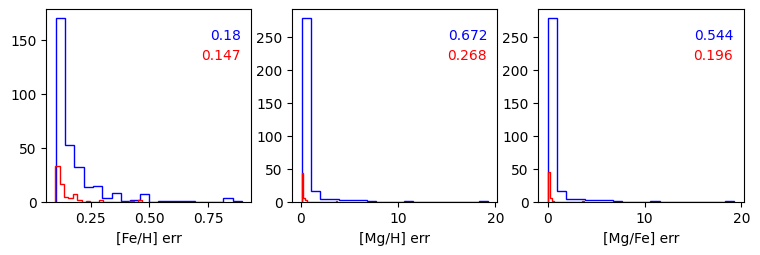

384


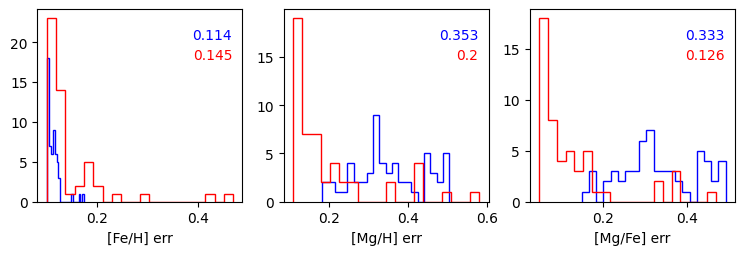

108


In [117]:
final_hsc_umi_e = final_hsc_umi[final_hsc_umi['by'] == 'Evan']
final_hsc_umi_l = final_hsc_umi[final_hsc_umi['by'] == 'Lauren']

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(9,2.5), gridspec_kw={'wspace':0.2})
ax0.hist(final_hsc_umi_e['FEHERR'], bins=20, color='b', histtype='step')
ax0.hist(final_hsc_umi_l['FEHERR'], bins=20, color='r', histtype='step')
ax0.set_xlabel('[Fe/H] err')
ax1.hist(final_hsc_umi_e['MGHERR'], bins=20, color='b', histtype='step')
ax1.hist(final_hsc_umi_l['MGHERR'], bins=20, color='r', histtype='step')
ax1.set_xlabel('[Mg/H] err')
ax2.hist(final_hsc_umi_e['MGFEERR'], bins=20, color='b', histtype='step')
ax2.hist(final_hsc_umi_l['MGFEERR'], bins=20, color='r', histtype='step')
ax2.set_xlabel('[Mg/Fe] err')
ax0.text(0.95, 0.90, f'{np.round(np.mean(final_hsc_umi_e.FEHERR),3)}', ha='right', va='top', transform=ax0.transAxes, color='b')
ax0.text(0.95, 0.80, f'{np.round(np.mean(final_hsc_umi_l.FEHERR),3)}', ha='right', va='top', transform=ax0.transAxes, color='r')
ax1.text(0.95, 0.90, f'{np.round(np.mean(final_hsc_umi_e.MGHERR),3)}', ha='right', va='top', transform=ax1.transAxes, color='b')
ax1.text(0.95, 0.80, f'{np.round(np.mean(final_hsc_umi_l.MGHERR),3)}', ha='right', va='top', transform=ax1.transAxes, color='r')
ax2.text(0.95, 0.90, f'{np.round(np.mean(final_hsc_umi_e.MGFEERR),3)}', ha='right', va='top', transform=ax2.transAxes, color='b')
ax2.text(0.95, 0.80, f'{np.round(np.mean(final_hsc_umi_l.MGFEERR),3)}', ha='right', va='top', transform=ax2.transAxes, color='r')
plt.show()
print(len(final_hsc_umi_e) + len(final_hsc_umi_l)) #263

final_hsc_umi_e = final_hsc_umi_e[(-0.0 < final_hsc_umi_e['MGFEERR']) & (final_hsc_umi_e['MGFEERR'] < 0.5)]
final_hsc_umi_l = final_hsc_umi_l[(-0.0 < final_hsc_umi_l['MGFEERR']) & (final_hsc_umi_l['MGFEERR'] < 0.5)]
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(9,2.5), gridspec_kw={'wspace':0.2})
ax0.hist(final_hsc_umi_e['FEHERR'], bins=20, color='b', histtype='step')
ax0.hist(final_hsc_umi_l['FEHERR'], bins=20, color='r', histtype='step')
ax0.set_xlabel('[Fe/H] err')
ax1.hist(final_hsc_umi_e['MGHERR'], bins=20, color='b', histtype='step')
ax1.hist(final_hsc_umi_l['MGHERR'], bins=20, color='r', histtype='step')
ax1.set_xlabel('[Mg/H] err')
ax2.hist(final_hsc_umi_e['MGFEERR'], bins=20, color='b', histtype='step')
ax2.hist(final_hsc_umi_l['MGFEERR'], bins=20, color='r', histtype='step')
ax2.set_xlabel('[Mg/Fe] err')
ax0.text(0.95, 0.90, f'{np.round(np.mean(final_hsc_umi_e.FEHERR),3)}', ha='right', va='top', transform=ax0.transAxes, color='b')
ax0.text(0.95, 0.80, f'{np.round(np.mean(final_hsc_umi_l.FEHERR),3)}', ha='right', va='top', transform=ax0.transAxes, color='r')
ax1.text(0.95, 0.90, f'{np.round(np.mean(final_hsc_umi_e.MGHERR),3)}', ha='right', va='top', transform=ax1.transAxes, color='b')
ax1.text(0.95, 0.80, f'{np.round(np.mean(final_hsc_umi_l.MGHERR),3)}', ha='right', va='top', transform=ax1.transAxes, color='r')
ax2.text(0.95, 0.90, f'{np.round(np.mean(final_hsc_umi_e.MGFEERR),3)}', ha='right', va='top', transform=ax2.transAxes, color='b')
ax2.text(0.95, 0.80, f'{np.round(np.mean(final_hsc_umi_l.MGFEERR),3)}', ha='right', va='top', transform=ax2.transAxes, color='r')
plt.show()
print(len(final_hsc_umi_e) + len(final_hsc_umi_l)) #93

# Draco

In [71]:
## read Subaru HSC cat file
input_catfile = 'hsc_data/draco_tpall3e_g24.cat'
df10 = ascii.read(input_catfile,
      names=['id', 'ra', 'dec', 'X', 'Y', 'ipsf', 'gpsf', 'npsf', 'ipsferr',
             'gpsferr', 'npsferr', 'cli', 'clg', 'cln', 'a_i', 'a_g', 'a_n'])
print(len(df10)) #83146
df10 = df10[(df10['cli'] == 0) & (df10['clg'] == 0) & (df10['cln'] == 0)]
print(len(df10)) #35414
df10['id'] = df10['id'].astype(float)
df10['g0'] = df10['gpsf'] - df10['a_g']
df10['i0'] = df10['ipsf'] - df10['a_i']
df10['n0'] = df10['npsf'] - df10['a_n']

83146
35414


In [72]:
## read DEIMOS fits file
input_fitsfile = 'deimos_data/alldsph_moogify.fits'
df11 = Table.read(input_fitsfile, format='fits')
df11 = df11[df11['DSPH'] == 'dra   ']
df11 = df11[['DSPH', 'OBJNAME', 'MASK', 'SLIT', 'RA', 'DEC',
            'B', 'V', 'R', 'I', 'J', 'H', 'K', 'BERR', 'VERR', 'RERR', 'IERR', 'JERR', 'HERR', 'KERR', 'PHOT_COLOR',
            'AGE', 'TEFF', 'TEFFERR', 'LOGG', 'LOGGERR',
            'FEH', 'FEHERR', 'ALPHAFE', 'ALPHAFEERR', 'MGFE', 'MGFEERR', 'SIFE', 'SIFEERR', 'CAFE', 'CAFEERR', 'TIFE', 'TIFEERR']]
df11 = df11.to_pandas()
df11.loc[:,'by'] = 'Evan'
for column in df11.columns:
    if df11[column].dtype == 'object' and isinstance(df11[column][0], bytes):
        df11[column] = df11[column].str.decode('utf-8')
df11 = df11.sort_values(by=['RA'], ascending=True)
print(len(df11)) #302

td0 = df11[df11['RA'] == 259.9726666609446]
td1 = df11[df11['RA'] == 260.0167916675408]
print(td0)
print(td1)

bad_ra_values = [259.9726666609446, 260.0167916675408]
bad_df11 = df11[df11['RA'].isin(bad_ra_values)]
good_df11 = df11[~df11['RA'].isin(bad_ra_values)]
print('len(bad_df11) =', len(bad_df11)) #2
print('len(good_df11) =', len(good_df11)) #300

302
      DSPH           OBJNAME     MASK  SLIT          RA        DEC         B  \
44  dra     638444            dra1       51  259.972667  57.937889  19.19197   

            V          R          I  ...  ALPHAFEERR      MGFE   MGFEERR  \
44  18.285441  17.698522  16.981948  ...    0.097592 -0.002251  0.300684   

        SIFE   SIFEERR      CAFE   CAFEERR      TIFE   TIFEERR    by  
44  0.130804  0.145503  0.002259  0.132689 -0.239195  0.139948  Evan  

[1 rows x 39 columns]
      DSPH           OBJNAME     MASK  SLIT          RA        DEC          B  \
50  dra     630851            dra1       59  260.016792  57.928778  21.032582   

           V          R          I  ...  ALPHAFEERR  MGFE  MGFEERR      SIFE  \
50  20.37197  19.969205  19.487947  ...    0.771886  -0.8     -0.0  0.367755   

     SIFEERR  CAFE  CAFEERR  TIFE  TIFEERR    by  
50  0.366123  -0.8     -0.0  -0.8     -0.0  Evan  

[1 rows x 39 columns]
len(bad_df11) = 2
len(good_df11) = 300


In [73]:
## read DEIMOS Lauren csv file
input_fitsfile = 'Mgabundances_Lauren/third/fulldataAlldSphs.csv'
df12 = pd.read_csv(input_fitsfile)
df12 = df12[['Name','RA','Dec','Galaxy','slitmask','Temp (K)','log(g)',
           '[Fe/H]','err([Fe/H])','[alpha/Fe]','[C/Fe]','[Mg/Fe]','errup([Mg/Fe])','errdown([Mg/Fe])','upper_[Mg/Fe]_twosigma','Mg_upperlimit',
           '[Sr/Fe]','errup([Sr/Fe])','errdown([Sr/Fe])','upper_[Sr/Fe]_twosigma','Sr_upperlimit',
           '[Y/Fe]','errup([Y/Fe])','errdown([Y/Fe])','upper_[Y/Fe]_twosigma','Y_upperlimit',
           '[Ba/Fe]','errup([Ba/Fe])','errdown([Ba/Fe])','upper_[Ba/Fe]_twosigma','Ba_upperlimit',
           '[La/Fe]','errup([La/Fe])','errdown([La/Fe])','upper_[La/Fe]_twosigma','La_upperlimit',
           '[Eu/Fe]','errup([Eu/Fe])','errdown([Eu/Fe])','upper_[Eu/Fe]_twosigma','Eu_upperlimit']]
df12 = df12[df12['Galaxy'] == 'Draco']
df12.loc[:,'by'] = 'Lauren'
df12 = df12.sort_values(by=['RA'], ascending=True)
print(len(df12)) #143

td0_l = df12[df12['RA'] == 259.9726666609446]
td1_l = df12[df12['RA'] == 260.0167916675408]
print(td0_l)
print(td1_l)

bad_ra_values = [259.9726666609446, 260.0167916675408]
bad_df12 = df12[df12['RA'].isin(bad_ra_values)]
good_df12 = df12[~df12['RA'].isin(bad_ra_values)]
print('len(bad_df12) =', len(bad_df12)) #2
print('len(good_df12) =', len(good_df12)) #141

143
       Name          RA        Dec Galaxy slitmask  Temp (K)  log(g)  [Fe/H]  \
484  638444  259.972667  57.937889  Draco    bdra1      4578    1.09   -1.84   

     err([Fe/H])  [alpha/Fe]  ...  errup([La/Fe])  errdown([La/Fe])  \
484          0.1        -0.1  ...            0.35              6.06   

     upper_[La/Fe]_twosigma  La_upperlimit  [Eu/Fe]  errup([Eu/Fe])  \
484                   -0.22            1.0     0.22            0.23   

     errdown([Eu/Fe])  upper_[Eu/Fe]_twosigma  Eu_upperlimit      by  
484               0.3                     NaN            0.0  Lauren  

[1 rows x 42 columns]
       Name          RA        Dec Galaxy slitmask  Temp (K)  log(g)  [Fe/H]  \
487  630851  260.016792  57.928778  Draco    bdra1      5184    2.32   -1.81   

     err([Fe/H])  [alpha/Fe]  ...  errup([La/Fe])  errdown([La/Fe])  \
487         0.16        -0.7  ...             NaN               NaN   

     upper_[La/Fe]_twosigma  La_upperlimit  [Eu/Fe]  errup([Eu/Fe])  \
487      

In [74]:
pd.options.mode.copy_on_write = True

df10['coord'] = SkyCoord(df10['ra'], df10['dec'], unit=(u.degree, u.degree))


#df11 = Table.from_pandas(df11)
#df11['coord'] = SkyCoord(df11['RA'], df11['DEC'], unit=(u.degree, u.degree))

bad_df11 = Table.from_pandas(bad_df11)
bad_df11['coord'] = SkyCoord(bad_df11['RA'], bad_df11['DEC'], unit=(u.degree, u.degree))

good_df11 = Table.from_pandas(good_df11)
good_df11['coord'] = SkyCoord(good_df11['RA'], good_df11['DEC'], unit=(u.degree, u.degree))


#df12 = Table.from_pandas(df12)
#df12['coord'] = SkyCoord(df12['RA'], df12['Dec'], unit=(u.degree, u.degree))

bad_df12 = Table.from_pandas(bad_df12)
bad_df12['coord'] = SkyCoord(bad_df12['RA'], bad_df12['Dec'], unit=(u.degree, u.degree))

good_df12 = Table.from_pandas(good_df12)
good_df12['coord'] = SkyCoord(good_df12['RA'], good_df12['Dec'], unit=(u.degree, u.degree))

In [75]:
## match HSC and DEIMOS

#df1011 = merge_catalogs(df10, df11, cat_names=['1', '2'], match_radius=1, join_type='outer')
#df1011 = df1011.to_pandas()
#print('len(df1011) =', len(df1011)) #

#The new header has 'header of df1' + 'coord_1.ra, coord_1.dec' + 'deimos header' + 'coord_2.ra, coord_2.dec'
#If the parameter names are same, it is changed, e.g., RA -> RA_1
bad_df1011 = merge_catalogs(df10, bad_df11, cat_names=['1', '2'], match_radius=1, join_type='outer')
bad_df1011 = bad_df1011.to_pandas()
print('len(bad_df1011) =', len(bad_df1011)) #4
print(bad_df1011['cli'])
print(bad_df1011['i0'])
bad_df1011_rm_dup = bad_df1011[bad_df1011['cli'] == 0]
print('len(bad_df1011_rm_dup) =', len(bad_df1011_rm_dup)) #2
print(bad_df1011_rm_dup['i0'])

good_df1011 = merge_catalogs(df10, good_df11, cat_names=['1', '2'], match_radius=1, join_type='outer')
good_df1011 = good_df1011.to_pandas()
print('len(good_df1011) =', len(good_df1011)) #286

df1011 = pd.concat([bad_df1011_rm_dup, good_df1011], axis=0)
print('len(df1011) =', len(df1011)) #288

df1011 = Table.from_pandas(df1011)

df1011.write('Draco_HSC_DEIMOS.fits', format='fits', overwrite='True')
#df1011.to_csv('Draco_HSC_DEIMOS.csv', index=False)

len(bad_df1011) = 2
0    0.0
1    0.0
Name: cli, dtype: float64
0    19.975786
1    17.603599
Name: i0, dtype: float64
len(bad_df1011_rm_dup) = 2
0    19.975786
1    17.603599
Name: i0, dtype: float64
len(good_df1011) = 286
len(df1011) = 288


In [76]:
print(Counter(df1011['cli']))
print(Counter(df1011['clg']))
print(Counter(df1011['cln']))

Counter({0.0: 288})
Counter({0.0: 288})
Counter({0.0: 288})


In [77]:
## match HSC and DEIMOS

#df1012 = merge_catalogs(df10, df12, cat_names=['1', '2'], match_radius=1, join_type='outer')
#df1012 = df1012.to_pandas()
#print('len(df1012) =', len(df1012)) #

#The new header has 'header of df1' + 'coord_1.ra, coord_1.dec' + 'deimos header' + 'coord_2.ra, coord_2.dec'
#If the parameter names are same, it is changed, e.g., RA -> RA_1
bad_df1012 = merge_catalogs(df10, bad_df12, cat_names=['1', '2'], match_radius=1, join_type='outer')
bad_df1012 = bad_df1012.to_pandas()
print('len(bad_df1012) =', len(bad_df1012)) #4
print(bad_df1012['cli'])
print(bad_df1012['i0'])
bad_df1012_rm_dup = bad_df1012[bad_df1012['cli'] == 0]
print('len(bad_df1012_rm_dup) =', len(bad_df1012_rm_dup)) #2
print(bad_df1012_rm_dup['i0'])

good_df1012 = merge_catalogs(df10, good_df12, cat_names=['1', '2'], match_radius=1, join_type='outer')
good_df1012 = good_df1012.to_pandas()
print('len(good_df1012) =', len(good_df1012)) #135

df1012 = pd.concat([bad_df1012_rm_dup, good_df1012], axis=0)
print('len(df1012) =', len(df1012)) #137

df1012 = Table.from_pandas(df1012)

df1012.write('Draco_HSC_Lauren.fits', format='fits', overwrite='True')
#df1012.to_csv('Draco_HSC_Lauren.csv', index=False)

len(bad_df1012) = 2
0    0.0
1    0.0
Name: cli, dtype: float64
0    19.975786
1    17.603599
Name: i0, dtype: float64
len(bad_df1012_rm_dup) = 2
0    19.975786
1    17.603599
Name: i0, dtype: float64
len(good_df1012) = 135
len(df1012) = 137


In [78]:
print(Counter(df1012['cli']))
print(Counter(df1012['clg']))
print(Counter(df1012['cln']))

Counter({0.0: 137})
Counter({0.0: 137})
Counter({0.0: 137})


In [79]:
## Draco
input_file_name = 'Draco_HSC_DEIMOS.fits'
table = Table.read(input_file_name, format='fits')
table['id'] = table['id'].astype(str)
table = table[['DSPH', 'OBJNAME', 'MASK', 'SLIT', 'RA', 'DEC',
              'B', 'V', 'R', 'I', 'J', 'H', 'K', 'BERR', 'VERR', 'RERR', 'IERR', 'JERR', 'HERR', 'KERR', 'PHOT_COLOR',
              'AGE', 'TEFF', 'TEFFERR', 'LOGG', 'LOGGERR',
              'FEH', 'FEHERR', 'ALPHAFE', 'ALPHAFEERR', 'MGFE', 'MGFEERR', 'SIFE', 'SIFEERR', 'CAFE', 'CAFEERR', 'TIFE', 'TIFEERR',
              'id', 'ra', 'dec', 'X', 'Y', 'ipsf', 'gpsf', 'npsf', 'ipsferr', 'gpsferr', 'npsferr', 'cli', 'clg', 'cln', 'a_i', 'a_g', 'a_n','by']]
df_dra_dei = table.to_pandas()
for column in df_dra_dei.columns:
    if df_dra_dei[column].dtype == 'object' and isinstance(df_dra_dei[column][0], bytes):
        df_dra_dei[column] = df_dra_dei[column].str.decode('utf-8')
df_dra_dei['g0'] = df_dra_dei['gpsf'] - df_dra_dei['a_g']
df_dra_dei['i0'] = df_dra_dei['ipsf'] - df_dra_dei['a_i']
df_dra_dei['n0'] = df_dra_dei['npsf'] - df_dra_dei['a_n']
df_dra_dei['MGH'] = df_dra_dei['MGFE'] + df_dra_dei['FEH']
df_dra_dei['MGHERR'] = np.sqrt(df_dra_dei['MGFEERR']**2 + df_dra_dei['FEHERR']**2)
#df_dra = df_dra[(0 < df_dra['FEHERR']) & (df_dra['FEHERR'] < 0.3) & (0 < df_dra['MGFEERR']) & (df_dra['MGFEERR'] < 0.3)]
#df_dra_dei = df_dra_dei[-0.0 < df_dra_dei['MGFEERR']]

print('len(df_dra_dei) =', len(df_dra_dei)) #134
#print('len(df_dra_dei MGFEERR == -0.0 =', len(df_dra_dei[df_dra_dei['MGFEERR'] == -0.0])) #
#df_dra_dei = df_dra_dei[-0.0 < df_dra_dei['MGFEERR']]
#print('len(df_dra_dei) =', len(df_dra_dei)) #

len(df_dra_dei) = 288


In [80]:
print(Counter(df_dra_dei['cli']))
print(Counter(df_dra_dei['clg']))
print(Counter(df_dra_dei['cln']))

Counter({0.0: 288})
Counter({0.0: 288})
Counter({0.0: 288})


In [81]:
## Draco
import warnings
from astropy.io.fits.verify import VerifyWarning
warnings.filterwarnings('ignore', category=VerifyWarning)

input_file_name = 'Draco_HSC_Lauren.fits'
table = Table.read(input_file_name, format='fits')
table = table[['Name', 'RA', 'Dec', 'Temp (K)',
               'log(g)', '[Fe/H]', 'err([Fe/H])', '[alpha/Fe]', '[Mg/Fe]', 'errup([Mg/Fe])', 'errdown([Mg/Fe])',
              'id', 'ra', 'dec', 'X', 'Y', 'ipsf', 'gpsf', 'npsf', 'ipsferr', 'gpsferr', 'npsferr', 'cli', 'clg', 'cln', 'a_i', 'a_g', 'a_n',
              'g0','i0','n0','by']]
df_dra_lau = table.to_pandas()
df_dra_lau['DSPH'] = 'dra'
df_dra_lau.rename(columns={'Name':'OBJNAME', 'Dec':'DEC', 'Temp (K)':'TEFF', 'log(g)':'LOGG',
                           '[Fe/H]':'FEH', 'err([Fe/H])':'FEHERR', '[alpha/Fe]':'ALPHAFE', '[Mg/Fe]':'MGFE'}, inplace=True)
df_dra_lau['MGFEERR'] = (df_dra_lau['errup([Mg/Fe])'] + df_dra_lau['errdown([Mg/Fe])']) / 2.
df_dra_lau.drop(['errup([Mg/Fe])', 'errdown([Mg/Fe])'], axis=1, inplace=True)
df_dra_lau[['MASK','SLIT','B', 'V', 'R', 'I', 'J', 'H', 'K', 'BERR', 'VERR', 'RERR', 'IERR', 'JERR', 'HERR', 'KERR', 'PHOT_COLOR',
            'AGE','TEFFERR','LOGGERR','ALPHAFEERR','SIFE', 'SIFEERR', 'CAFE', 'CAFEERR', 'TIFE', 'TIFEERR']] = np.nan

for column in df_dra_lau.columns:
    if df_dra_lau[column].dtype == 'object' and isinstance(df_dra_lau[column][0], bytes):
        df_dra_lau[column] = df_dra_lau[column].str.decode('utf-8')
df_dra_lau['MGH'] = df_dra_lau['MGFE'] + df_dra_lau['FEH']
df_dra_lau['MGHERR'] = np.sqrt(df_dra_lau['MGFEERR']**2 + df_dra_lau['FEHERR']**2)

df_dra_lau = df_dra_lau[['DSPH', 'OBJNAME', 'MASK', 'SLIT', 'RA', 'DEC',
              'B', 'V', 'R', 'I', 'J', 'H', 'K', 'BERR', 'VERR', 'RERR', 'IERR', 'JERR', 'HERR', 'KERR', 'PHOT_COLOR',
              'AGE', 'TEFF', 'TEFFERR', 'LOGG', 'LOGGERR',
              'FEH', 'FEHERR', 'ALPHAFE', 'ALPHAFEERR', 'MGFE', 'MGFEERR', 'MGH', 'MGHERR', 'SIFE', 'SIFEERR', 'CAFE', 'CAFEERR', 'TIFE', 'TIFEERR',
              'id', 'ra', 'dec', 'X', 'Y', 'ipsf', 'gpsf', 'npsf', 'ipsferr', 'gpsferr', 'npsferr', 'cli', 'clg', 'cln', 'a_i', 'a_g', 'a_n',
              'g0','i0','n0','by']]

print('len(df_dra_lau) =', len(df_dra_lau)) #137

len(df_dra_lau) = 137


In [82]:
print(Counter(df_dra_lau['cli']))
print(Counter(df_dra_lau['clg']))
print(Counter(df_dra_lau['cln']))

Counter({0.0: 137})
Counter({0.0: 137})
Counter({0.0: 137})


In [83]:
print(Counter(df_dra_dei['DSPH']))
print(Counter(df_dra_lau['DSPH']))

Counter({'dra': 288})
Counter({'dra': 137})


In [84]:
df_dra = pd.concat([df_dra_dei, df_dra_lau], axis=0)
print(df_dra) #425

    DSPH OBJNAME  MASK  SLIT          RA        DEC          B          V  \
0    dra  630851  dra1  59.0  260.016792  57.928778  21.032582  20.371970   
1    dra  638444  dra1  51.0  259.972667  57.937889  19.191970  18.285441   
2    dra  620075  dra5   7.0  260.839417  57.915194  20.933209  20.215697   
3    dra  598401  dra5  47.0  260.718625  57.882111  22.935182  22.299688   
4    dra  629966  dra5  12.0  260.760208  57.927722  21.554687  20.868617   
..   ...     ...   ...   ...         ...        ...        ...        ...   
132  dra  659993   NaN   NaN  259.784667  57.964056        NaN        NaN   
133  dra  678863   NaN   NaN  259.795042  57.988167        NaN        NaN   
134  dra  682782   NaN   NaN  259.752125  57.993278        NaN        NaN   
135  dra  691432   NaN   NaN  259.782208  58.005472        NaN        NaN   
136  dra  667675   NaN   NaN  259.722792  57.973889        NaN        NaN   

             R          I  ...  cln     a_i     a_g     a_n      by  \
0   

In [85]:
df_dra = df_dra.drop_duplicates(subset=['id'], keep='first') #keep the first one among dups
print(len(df_dra)) #425

425


In [86]:
test = df_dra[(df_dra['gpsferr'] != np.inf) & (df_dra['ipsferr'] != np.inf) & (df_dra['npsferr'] != np.inf)]
print(len(test)) #425

425


In [87]:
print(df_dra.columns.values)

['DSPH' 'OBJNAME' 'MASK' 'SLIT' 'RA' 'DEC' 'B' 'V' 'R' 'I' 'J' 'H' 'K'
 'BERR' 'VERR' 'RERR' 'IERR' 'JERR' 'HERR' 'KERR' 'PHOT_COLOR' 'AGE'
 'TEFF' 'TEFFERR' 'LOGG' 'LOGGERR' 'FEH' 'FEHERR' 'ALPHAFE' 'ALPHAFEERR'
 'MGFE' 'MGFEERR' 'SIFE' 'SIFEERR' 'CAFE' 'CAFEERR' 'TIFE' 'TIFEERR' 'id'
 'ra' 'dec' 'X' 'Y' 'ipsf' 'gpsf' 'npsf' 'ipsferr' 'gpsferr' 'npsferr'
 'cli' 'clg' 'cln' 'a_i' 'a_g' 'a_n' 'by' 'g0' 'i0' 'n0' 'MGH' 'MGHERR']


In [88]:
df_dra.to_csv('Draco_HSC_Evan_Lauren_before_pm.csv', index=False)

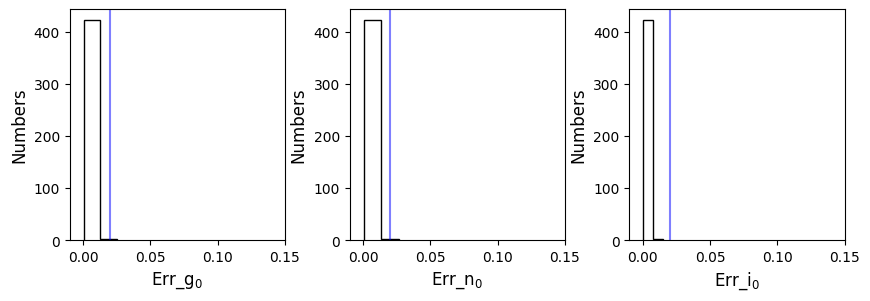

After class cut, 
df_dra_mag_err = 423


In [89]:
# Plots of mag err
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(10,3), gridspec_kw={'wspace':0.3})

ax0.hist(df_dra['gpsferr'], bins=2, histtype='step', linestyle='solid', color='k')
ax0.set_xlim([-0.01, 0.15])
ax0.set_xlabel('Err_g$_{0}$', size=12)
ax0.set_ylabel('Numbers', size=12)
ax0.axvline(0.02, 0, 40000, color='blue', linestyle='-', alpha=0.5)
ax1.hist(df_dra['npsferr'], bins=2, histtype='step', linestyle='solid', color='k')
ax1.set_xlim([-0.01, 0.15])
ax1.set_xlabel('Err_n$_{0}$', size=12)
ax1.set_ylabel('Numbers', size=12)
ax1.axvline(0.02, 0, 40000, color='blue', linestyle='-', alpha=0.5)
ax2.hist(df_dra['ipsferr'], bins=2, histtype='step', linestyle='solid', color='k')
ax2.set_xlim([-0.01, 0.15])
ax2.set_xlabel('Err_i$_{0}$', size=12)
ax2.set_ylabel('Numbers', size=12)
ax2.axvline(0.02, 0, 40000, color='blue', linestyle='-', alpha=0.5)
plt.show()

# Apply the magnitude err
df_dra_mag_err = df_dra[(df_dra['gpsferr'] < 0.02) & (df_dra['ipsferr'] < 0.02) & (df_dra['npsferr'] < 0.02)]
print(f'After class cut, \ndf_dra_mag_err = {len(df_dra_mag_err)}') #271

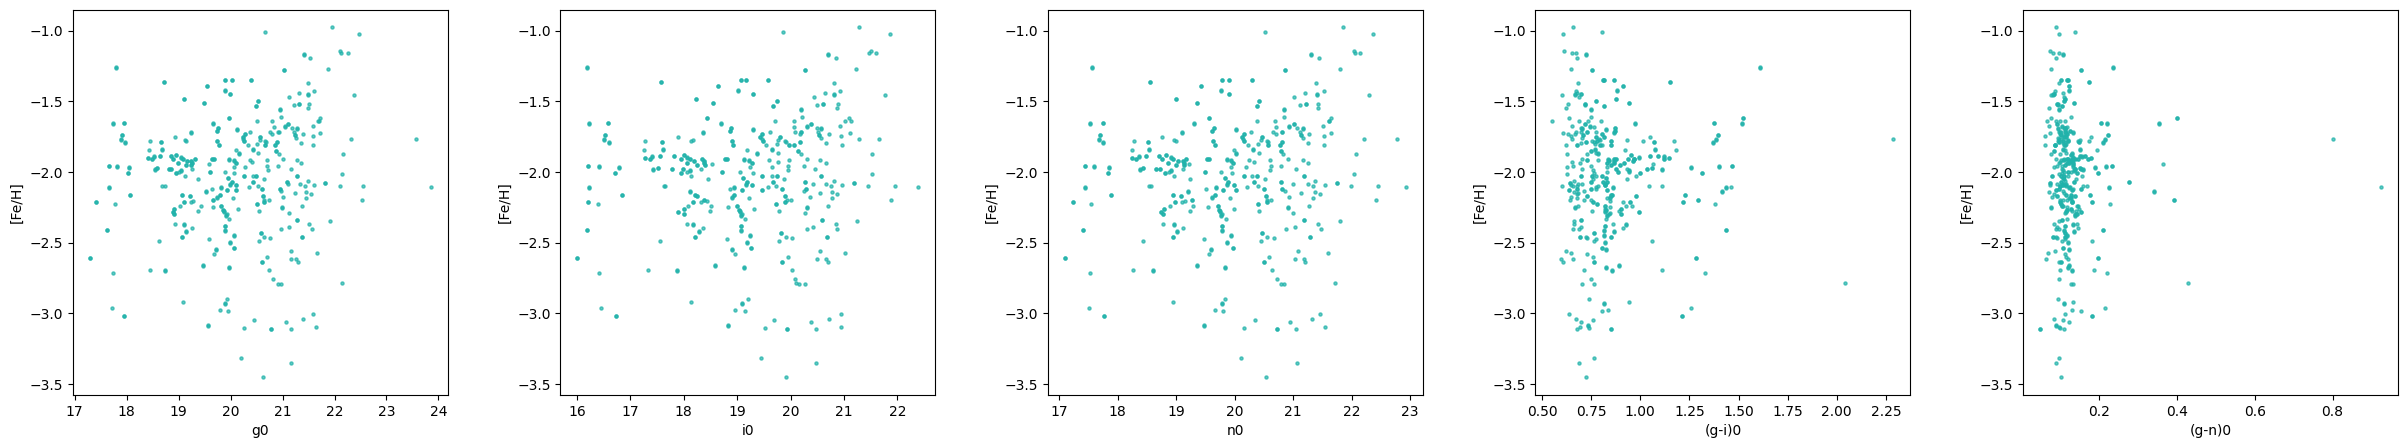

In [90]:
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=5, figsize=(30,5), gridspec_kw={'wspace':0.3})

ax0.scatter(df_dra['g0'], df_dra['FEH'], s=5, color='lightseagreen', alpha=.7)
ax0.set_xlabel('g0')
ax0.set_ylabel('[Fe/H]')

ax1.scatter(df_dra['i0'], df_dra['FEH'], s=5, color='lightseagreen', alpha=.7)
ax1.set_xlabel('i0')
ax1.set_ylabel('[Fe/H]')

ax2.scatter(df_dra['n0'], df_dra['FEH'], s=5, color='lightseagreen', alpha=.7)
ax2.set_xlabel('n0')
ax2.set_ylabel('[Fe/H]')

ax3.scatter(df_dra['g0']-df_dra['i0'], df_dra['FEH'], s=5, color='lightseagreen', alpha=.7)
ax3.set_xlabel('(g-i)0')
ax3.set_ylabel('[Fe/H]')

ax4.scatter(df_dra['g0']-df_dra['n0'], df_dra['FEH'], s=5, color='lightseagreen', alpha=.7)
ax4.set_xlabel('(g-n)0')
ax4.set_ylabel('[Fe/H]')

#plt.show()
plt.savefig('DEIMOS_non_linear_relationships_Draco.png', bbox_inches='tight')

len(df4_gaia) = 425
len(df4_gaia_sc) = 425
len(df4_gaia_sc_magerr) = 423
len(df4_gaia_sc_magerr_availpm) = 360
len(df4_gaia_sc_magerr_nonpm) = 63
clipped mean pmRA pmDE = 0.038 -0.214
clipped std pmRA pmDE = 0.028 0.024
r_a, r_b = 0.084 0.072
len(filtered data) = 360
len(inside the ellipse) = 38
len(filtered_df4_gaia_sc_magerr_availpm_nonpm) = 423
len(df4_gaia_sc_magerr_availpm_inside_polygon) = 346


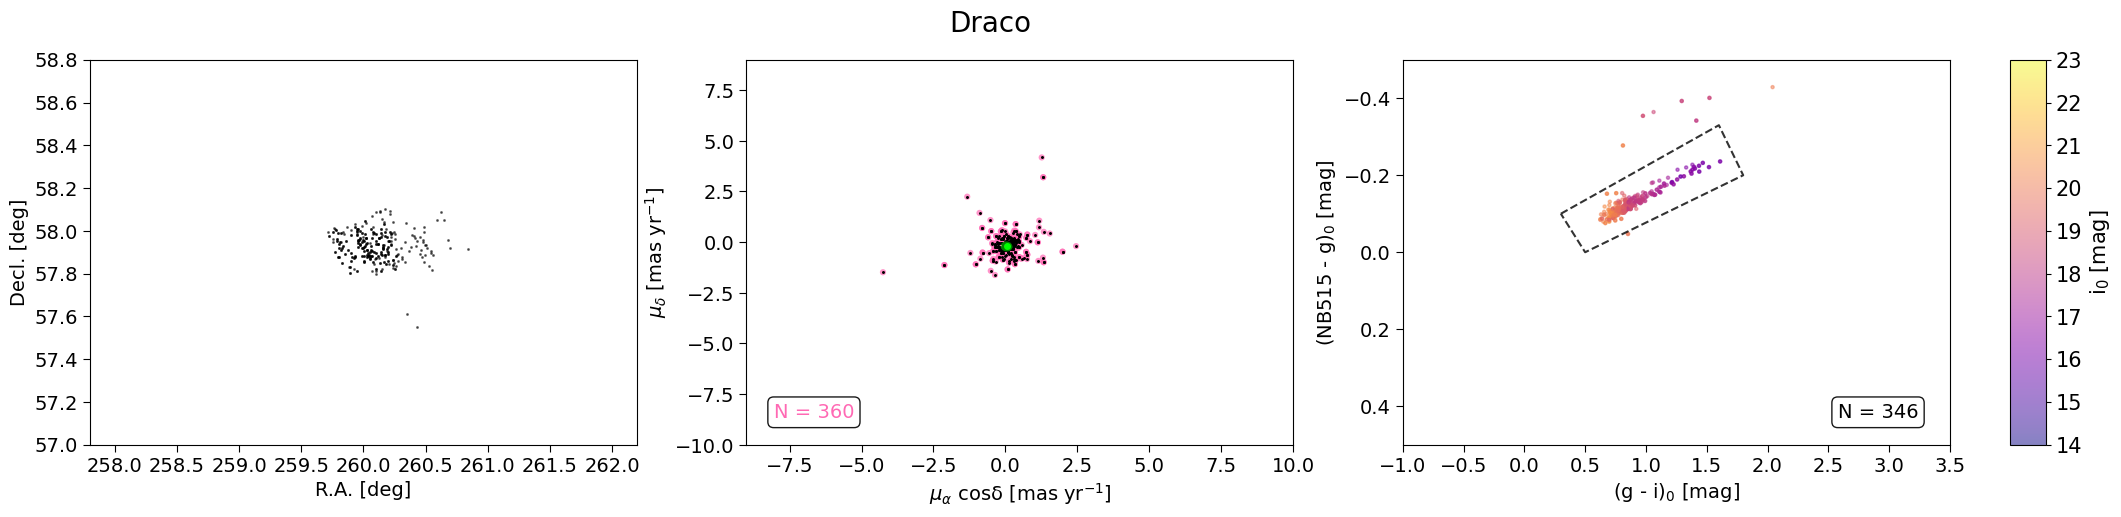

In [91]:
# Test the sample with Gaia DR3
df4_gaia = pd.read_csv('Draco_HSC_Evan_Lauren_after_pm.csv')
print(f'len(df4_gaia) = {len(df4_gaia)}') #425
df4_gaia_sc = df4_gaia[(df4_gaia['cli'] == 0) & (df4_gaia['clg'] == 0) & (df4_gaia['cln'] == 0)]
print(f'len(df4_gaia_sc) = {len(df4_gaia_sc)}') #425
df4_gaia_sc_magerr = df4_gaia_sc[(df4_gaia_sc['gpsferr'] < 0.02) & (df4_gaia_sc['ipsferr'] < 0.02) & (df4_gaia_sc['npsferr'] < 0.02)]
print(f'len(df4_gaia_sc_magerr) = {len(df4_gaia_sc_magerr)}') #423
df4_gaia_sc_magerr_availpm = df4_gaia_sc_magerr[df4_gaia_sc_magerr['pmRA'].notnull()]
print('len(df4_gaia_sc_magerr_availpm) =', len(df4_gaia_sc_magerr_availpm)) #360
df4_gaia_sc_magerr_nonpm = df4_gaia_sc_magerr[df4_gaia_sc_magerr['pmRA'].isnull()]
print('len(df4_gaia_sc_magerr_nonpm) =', len(df4_gaia_sc_magerr_nonpm)) #63

# Left
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(24, 5), gridspec_kw={'wspace':0.2})
fig.suptitle('Draco', size=20, y=0.98)
alpha = .5 ; s = 5
axs[0].scatter(df4_gaia_sc_magerr_availpm['ra'], df4_gaia_sc_magerr_availpm['dec'], marker='.', s=s, color='k', alpha=.5)
axs[0].set_xlabel('R.A. [deg]', size=14)
axs[0].set_ylabel('Decl. [deg]', size=14)
axs[0].set_xlim([257.8, 262.2])
axs[0].set_ylim([57, 58.8])
axs[0].tick_params(axis='x', which='major', direction='out', right=False, top=False, length=5, labelsize=14)
axs[0].tick_params(axis='x', which='minor', direction='out', right=False, top=False, length=3, labelsize=14)
axs[0].tick_params(axis='y', which='major', direction='out', right=False, top=False, length=5, labelsize=14)
axs[0].tick_params(axis='y', which='minor', direction='out', right=False, top=False, length=3, labelsize=14)


# Middle
#pmra_0, pmdec_0 = -0.01, 0.2 # McConnachie et al. 2020
#r_a, r_b = 0.85, 0.85 # manually / std of pmRA pmDE = 12.22 10.46
pmRA = df4_gaia_sc_magerr_availpm['pmRA']
pmDE = df4_gaia_sc_magerr_availpm['pmDE']
err_pmra = df4_gaia_sc_magerr_availpm['e_pmRA']
err_pmdec = df4_gaia_sc_magerr_availpm['e_pmDE']
err_pm = np.sqrt(err_pmra**2 + err_pmdec**2)
# Sigma Clipping
clipped_pmRA = sigma_clip(pmRA, sigma=1.5, maxiters=10, stdfunc=np.std)
clipped_pmDE = sigma_clip(pmDE, sigma=1.5, maxiters=10, stdfunc=np.std)
mean_pmRA = np.round(np.mean(clipped_pmRA), 3)
mean_pmDE = np.round(np.mean(clipped_pmDE), 3)
std_pmRA = np.round(np.std(clipped_pmRA), 3)
std_pmDE = np.round(np.std(clipped_pmDE), 3)
print('clipped mean pmRA pmDE =', mean_pmRA, mean_pmDE) # -0.033 -0.206
print('clipped std pmRA pmDE =', std_pmRA, std_pmDE) #0.351 0.31
pmra_0, pmdec_0 = mean_pmRA, mean_pmDE
r_a, r_b = np.round(std_pmRA * 3, 3), np.round(std_pmDE * 3, 3)
print('r_a, r_b =', r_a, r_b) #1.053 0.930
axs[1].plot(pmra_0, pmdec_0, marker='o', markersize=4, color='lime')
ellipse = Ellipse(xy=[pmra_0, pmdec_0], width=r_a*2, height=r_b*2, angle=150, edgecolor='lime', fc='None', lw=5, alpha=0.5)
axs[1].add_patch(ellipse)
angle = ellipse.angle

def within_ellipse(x, y, x_0, y_0, r_a, r_b):
    theta = np.radians(360 - angle)
    x_rot = x * np.cos(theta) - y * np.sin(theta)
    y_rot = x * np.sin(theta) + y * np.cos(theta)
    x_0_rot = x_0 * np.cos(theta) - y_0 * np.sin(theta)
    y_0_rot = x_0 * np.sin(theta) + y_0 * np.cos(theta)
    return ( (r_b * (x_rot - x_0_rot))**2 + (r_a * (y_rot - y_0_rot))**2 ) <= (r_a * r_b)**2

def within_ellipse_w_errpm(x, y, x_0, y_0, r_a, r_b, err_pm):
    theta = np.radians(360 - angle)
    x_rot = x * np.cos(theta) - y * np.sin(theta)
    y_rot = x * np.sin(theta) + y * np.cos(theta)
    x_0_rot = x_0 * np.cos(theta) - y_0 * np.sin(theta)
    y_0_rot = x_0 * np.sin(theta) + y_0 * np.cos(theta)
    return ( (r_b * (x_rot - x_0_rot))**2 + (r_a * (y_rot - y_0_rot))**2 ) <= (r_a * r_b)**2 + (3 * err_pm)**2

theta = np.radians(360 - angle)

mask = df4_gaia_sc_magerr_availpm.apply(lambda row: within_ellipse_w_errpm(row['pmRA'], row['pmDE'], pmra_0, pmdec_0, r_a, r_b, np.sqrt(row['e_pmRA']**2 + row['e_pmDE']**2)), axis=1)
filtered_df4_gaia_sc_magerr_availpm = df4_gaia_sc_magerr_availpm[mask]
print('len(filtered data) =', len(filtered_df4_gaia_sc_magerr_availpm)) #360
axs[1].scatter(filtered_df4_gaia_sc_magerr_availpm['pmRA'], filtered_df4_gaia_sc_magerr_availpm['pmDE'], marker='o', s=20, facecolor='hotpink', edgecolor='none', alpha=0.7)
props = dict(boxstyle='round', facecolor='white', alpha=0.9)
axs[1].text(0.05, 0.07, 'N = {}'.format(len(filtered_df4_gaia_sc_magerr_availpm)), transform=axs[1].transAxes, fontsize=14, color='hotpink', bbox=props)

axs[1].scatter(df4_gaia_sc_magerr_availpm['pmRA'], df4_gaia_sc_magerr_availpm['pmDE'], marker='.', s=s, color='k', alpha=1)
axs[1].set_xlabel('$\mu_{\\alpha}~\mathrm{cos\delta}$ [mas yr$^{-1}$]', size=14)
axs[1].set_ylabel('$\mu_{\delta}$ [mas yr$^{-1}$]', size=14)
axs[1].set_xlim([-9, 10])
axs[1].set_ylim([-10, 9])
axs[1].add_patch(ellipse)
axs[1].tick_params(axis='x', which='major', direction='out', right=False, top=False, length=5, labelsize=14)
axs[1].tick_params(axis='x', which='minor', direction='out', right=False, top=False, length=3, labelsize=14)
axs[1].tick_params(axis='y', which='major', direction='out', right=False, top=False, length=5, labelsize=14)
axs[1].tick_params(axis='y', which='minor', direction='out', right=False, top=False, length=3, labelsize=14)

mask_test = df4_gaia_sc_magerr_availpm.apply(lambda row: within_ellipse(row['pmRA'], row['pmDE'], pmra_0, pmdec_0, r_a, r_b), axis=1)
inside_ellipse_test = df4_gaia_sc_magerr_availpm[mask_test]
print('len(inside the ellipse) =', len(inside_ellipse_test)) #38

filtered_df4_gaia_sc_magerr_availpm_nonpm = pd.concat([df4_gaia_sc_magerr_nonpm, filtered_df4_gaia_sc_magerr_availpm], axis=0)
print('len(filtered_df4_gaia_sc_magerr_availpm_nonpm) =', len(filtered_df4_gaia_sc_magerr_availpm_nonpm)) #423


# Right
cax = fig.add_axes([axs[2].get_position().x1+0.025, axs[2].get_position().y0, 0.015, axs[2].get_position().height])
img = axs[2].scatter(filtered_df4_gaia_sc_magerr_availpm['g0'] - filtered_df4_gaia_sc_magerr_availpm['i0'], 
                     filtered_df4_gaia_sc_magerr_availpm['n0'] - filtered_df4_gaia_sc_magerr_availpm['g0'], 
                     marker='o', s=s, c=filtered_df4_gaia_sc_magerr_availpm['i0'], cmap='plasma', alpha=alpha)
axs[2].set_xlim([-1, 3.5])
axs[2].set_ylim([0.5, -0.5])
axs[2].set_xlabel('(g - i)$_{0}$ [mag]', size=14)
axs[2].set_ylabel('(NB515 - g)$_{0}$ [mag]', size=14)
axs[2].tick_params(axis='x', which='major', direction='out', right=False, top=False, length=5, labelsize=14)
axs[2].tick_params(axis='x', which='minor', direction='out', right=False, top=False, length=3, labelsize=14)
axs[2].tick_params(axis='y', which='major', direction='out', right=False, top=False, length=5, labelsize=14)
axs[2].tick_params(axis='y', which='minor', direction='out', right=False, top=False, length=3, labelsize=14)
cbar = plt.colorbar(img, cax=cax)
cbar.ax.tick_params(labelsize=15)
cbar.set_label('i$_{0}$ [mag]', size=15)
cbar.mappable.set_clim(vmin=14, vmax=23)
cbar.update_ticks()
coord = [[0.3, -0.1], [1.6, -0.33], [1.8, -0.2], [0.5, 0], [0.3, -0.1]]
xs, ys = zip(*coord)
axs[2].plot(xs, ys, linestyle='--', linewidth=1.5, alpha=.8, color='k')
polygon = Path(coord)
points = np.vstack((filtered_df4_gaia_sc_magerr_availpm['g0'] - filtered_df4_gaia_sc_magerr_availpm['i0'], 
                    filtered_df4_gaia_sc_magerr_availpm['n0'] - filtered_df4_gaia_sc_magerr_availpm['g0'])).T
inside = polygon.contains_points(points)
df4_gaia_sc_magerr_availpm_inside_polygon = filtered_df4_gaia_sc_magerr_availpm[inside]
props = dict(boxstyle='round', facecolor='white', alpha=0.9)
axs[2].text(0.795, 0.07, 'N = {}'.format(len(df4_gaia_sc_magerr_availpm_inside_polygon)), transform=axs[2].transAxes, fontsize=14, color='black', bbox=props)
print('len(df4_gaia_sc_magerr_availpm_inside_polygon) =', len(df4_gaia_sc_magerr_availpm_inside_polygon)) #346

#plt.show()
plt.savefig('DEIMOS_ccd_select_sample_Draco_pm.png', bbox_inches='tight')

In [118]:
final_hsc_dra = df4_gaia_sc_magerr_availpm_inside_polygon
print(f'len(final_hsc_dra) = {len(final_hsc_dra)}') #346
final_hsc_dra.to_csv('Draco_DEIMOS_Evan_Lauren.csv', index=False)

len(final_hsc_dra) = 346


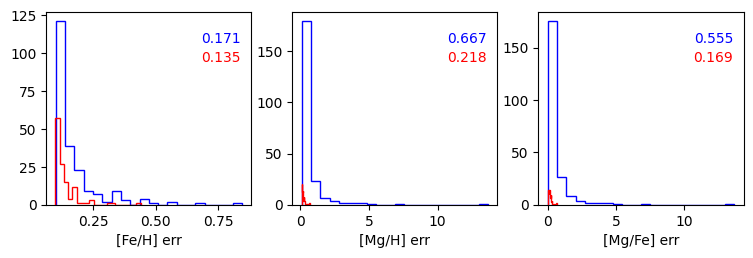

346


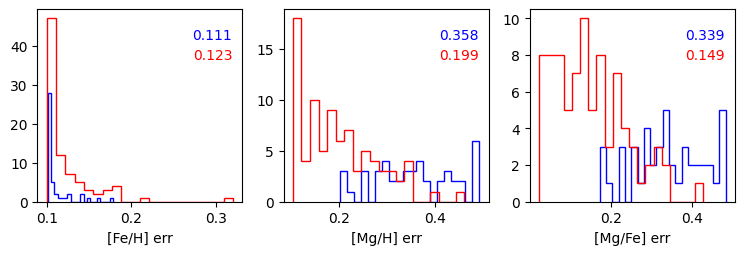

130


In [119]:
final_hsc_dra_e = final_hsc_dra[final_hsc_dra['by'] == 'Evan']
final_hsc_dra_l = final_hsc_dra[final_hsc_dra['by'] == 'Lauren']

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(9,2.5), gridspec_kw={'wspace':0.2})
ax0.hist(final_hsc_dra_e['FEHERR'], bins=20, color='b', histtype='step')
ax0.hist(final_hsc_dra_l['FEHERR'], bins=20, color='r', histtype='step')
ax0.set_xlabel('[Fe/H] err')
ax1.hist(final_hsc_dra_e['MGHERR'], bins=20, color='b', histtype='step')
ax1.hist(final_hsc_dra_l['MGHERR'], bins=20, color='r', histtype='step')
ax1.set_xlabel('[Mg/H] err')
ax2.hist(final_hsc_dra_e['MGFEERR'], bins=20, color='b', histtype='step')
ax2.hist(final_hsc_dra_l['MGFEERR'], bins=20, color='r', histtype='step')
ax2.set_xlabel('[Mg/Fe] err')
ax0.text(0.95, 0.90, f'{np.round(np.mean(final_hsc_dra_e.FEHERR),3)}', ha='right', va='top', transform=ax0.transAxes, color='b')
ax0.text(0.95, 0.80, f'{np.round(np.mean(final_hsc_dra_l.FEHERR),3)}', ha='right', va='top', transform=ax0.transAxes, color='r')
ax1.text(0.95, 0.90, f'{np.round(np.mean(final_hsc_dra_e.MGHERR),3)}', ha='right', va='top', transform=ax1.transAxes, color='b')
ax1.text(0.95, 0.80, f'{np.round(np.mean(final_hsc_dra_l.MGHERR),3)}', ha='right', va='top', transform=ax1.transAxes, color='r')
ax2.text(0.95, 0.90, f'{np.round(np.mean(final_hsc_dra_e.MGFEERR),3)}', ha='right', va='top', transform=ax2.transAxes, color='b')
ax2.text(0.95, 0.80, f'{np.round(np.mean(final_hsc_dra_l.MGFEERR),3)}', ha='right', va='top', transform=ax2.transAxes, color='r')
plt.show()
print(len(final_hsc_dra_e) + len(final_hsc_dra_l)) #168

final_hsc_dra_e = final_hsc_dra_e[(-0.0 < final_hsc_dra_e['MGFEERR']) & (final_hsc_dra_e['MGFEERR'] < 0.5)]
final_hsc_dra_l = final_hsc_dra_l[(-0.0 < final_hsc_dra_l['MGFEERR']) & (final_hsc_dra_l['MGFEERR'] < 0.5)]
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(9,2.5), gridspec_kw={'wspace':0.2})
ax0.hist(final_hsc_dra_e['FEHERR'], bins=20, color='b', histtype='step')
ax0.hist(final_hsc_dra_l['FEHERR'], bins=20, color='r', histtype='step')
ax0.set_xlabel('[Fe/H] err')
ax1.hist(final_hsc_dra_e['MGHERR'], bins=20, color='b', histtype='step')
ax1.hist(final_hsc_dra_l['MGHERR'], bins=20, color='r', histtype='step')
ax1.set_xlabel('[Mg/H] err')
ax2.hist(final_hsc_dra_e['MGFEERR'], bins=20, color='b', histtype='step')
ax2.hist(final_hsc_dra_l['MGFEERR'], bins=20, color='r', histtype='step')
ax2.set_xlabel('[Mg/Fe] err')
ax0.text(0.95, 0.90, f'{np.round(np.mean(final_hsc_dra_e.FEHERR),3)}', ha='right', va='top', transform=ax0.transAxes, color='b')
ax0.text(0.95, 0.80, f'{np.round(np.mean(final_hsc_dra_l.FEHERR),3)}', ha='right', va='top', transform=ax0.transAxes, color='r')
ax1.text(0.95, 0.90, f'{np.round(np.mean(final_hsc_dra_e.MGHERR),3)}', ha='right', va='top', transform=ax1.transAxes, color='b')
ax1.text(0.95, 0.80, f'{np.round(np.mean(final_hsc_dra_l.MGHERR),3)}', ha='right', va='top', transform=ax1.transAxes, color='r')
ax2.text(0.95, 0.90, f'{np.round(np.mean(final_hsc_dra_e.MGFEERR),3)}', ha='right', va='top', transform=ax2.transAxes, color='b')
ax2.text(0.95, 0.80, f'{np.round(np.mean(final_hsc_dra_l.MGFEERR),3)}', ha='right', va='top', transform=ax2.transAxes, color='r')
plt.show()
print(len(final_hsc_dra_e) + len(final_hsc_dra_l)) #93